# **COMP9727 Recommender Systems**
## Assignment: Content-Based Music Recommender System

@Author: **Merry Rosalie (z5391208)**

### Objective

The objective of this assignment is to implement a **"content-based music recommender system"** that may be used by streaming services (like Spotify) to provide personalised playlists of songs based on user profiles.

This system will classify new songs into topics based on their information (artist name, track name, release date, genre, and lyrics) using topic classification, and then use these classifications to recommend similar songs to users.

The assignment consists of 3 main parts: _topic classification (part 1)_, _recommendation methods (part 2)_, and _user evaluation (part 3)_.

### Part 1 - Topic Classification

#### 1.1. Introduction

Topic classification is a supervised machine learning method where we assign predefined categories or topics to text documents. In our context, we aim to classify songs into one of topics: _dark_, _emotion_, _lifestyle_, _personal_, and _sadness_ based on the textual information available for each song (artist name, track name, release date, genre and lyrics).

**Goals:**
1. Develop a text preprocessing pipeline that maximises classification accuracy.
2. Compare Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB) classifiers.
3. Optimise feature selection by varying the number of top features used.
4. Implement and evaluate an alternative classification method to Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB).
5. Choose the best overall approach for topic classification to be used in the recommender system.

#### 1.2. Data Preparation, Preprocessing and Implementation

This section builds the foundation of our topic classification system by loading, cleaning, and preprocessing the dataset. This step is important because unstructured data needs to be preprocessed to transform them into features that classifiers can use effectively.

__1.2.1. Load the Dataset__

We start by loading our dataset into a dataframe. Our dataset contains 1500 songs with the following fields:
- **artist_name**: The name of the performing artist
- **track_name**: The title of the song
- **release_date**: The year of release
- **genre**: Musical genre (rock, blues, jazz, etc)
- **lyrics**: The full text of the song's lyrics
- **topic**: The thematic label for the song. This will used to evaluate the performance of our classifiers.

In [1]:
import pandas as pd

pd.reset_option("display.max_colwidth") # Restore default column width limit

# Load the dataset
df = pd.read_csv("dataset.tsv", sep="\t", header=0)

# Display dataset overview
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print(f"\nTotal songs: {len(df)}")
print(f"Unique artists: {df['artist_name'].nunique()}")
print(f"Unique genres: {df['genre'].nunique()}")
print(f"Unique topics: {df['topic'].nunique()}")
print(f"Date range: {df['release_date'].min()} - {df['release_date'].max()}")

print(f"\nFirst few rows:")
print(df.head())

Dataset shape: (1500, 6)
Columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']

Total songs: 1500
Unique artists: 803
Unique genres: 7
Unique topics: 5
Date range: 2016 - 2019

First few rows:
                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre                                             lyrics      topic  
0   rock  awake know go see time clear world mirror worl...       dark  
1   rock  shouldn summer pretty build spill ready overfl...  lifestyle  
2  blues  lose deep catch breath think say try break wal...    sadness  
3  blues  run bitter taste ta

__1.2.2. Data cleansing__

Before preprocessing, we need to ensure data quality by removing duplicates and handling missing values.

In [2]:
# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Remove duplicates and missing values
df = df.drop_duplicates().dropna()
print(f"\nDataset shape after cleaning: {df.shape}")

Duplicate rows: 20

Missing values per column:
artist_name     0
track_name      0
release_date    0
genre           0
lyrics          0
topic           0
dtype: int64

Dataset shape after cleaning: (1480, 6)


To align with the specification, we define a function `create_combined_document` that merges all textual information (`artist_name`, `track_name`, `genre`, and `lyrics`) into a single document. This ensures that the model learns from the full context of each song. Fields such as `topic` and `release_date` are deliberately excluded, as they are either target labels or unlikely to contribute to insights for our topic classification.

In [3]:
def create_combined_document(row):
    document = f"{row['artist_name']} {row['track_name']} {row['genre']} {row['lyrics']}"
    return document

# Create a document for each row in the dataset
df["combined_text"] = df.apply(create_combined_document, axis=1)
df[["artist_name", "track_name", "genre", "lyrics", "combined_text"]].head()

,artist_name,track_name,genre,lyrics,combined_text
0,loving,the not real lake,rock,awake know go see time clear world mirror worl...,loving the not real lake rock awake know go se...
1,incubus,into the summer,rock,shouldn summer pretty build spill ready overfl...,incubus into the summer rock shouldn summer pr...
2,reignwolf,hardcore,blues,lose deep catch breath think say try break wal...,reignwolf hardcore blues lose deep catch breat...
3,tedeschi trucks band,anyhow,blues,run bitter taste take rest feel anchor soul pl...,tedeschi trucks band anyhow blues run bitter t...
4,lukas nelson and promise of the real,if i started over,blues,think think different set apart sober mind sym...,lukas nelson and promise of the real if i star...


__1.2.3. Text Preprocessing__

Raw text data is inherently unstructured and often includes noise like punctuation, stopwords, and others. As a result, preprocessing plays an important role in cleaning and standardising the text, so that it can be used by our classifiers more effectively.

In this assignment, we define a function named `preprocess_text` to perform all preprocessing steps, which are then applied to each document in the dataframe. The preprocessing pipeline consists of the following components:

1. **Regular Expressions (`re` library)**: Usually we use regular expressions to clean text through pattern matching to remove all punctuations. However, this can remove all punctuation indiscriminately, which may lose linguistically meaningful structures. Instead, we take a less aggressive approach by initially preserving apostrophes and hyphens using `r"[^\w\s'-]"` to maintain meaningful words like "don't" or "self-love". We then handle these punctuations separately: converting hyphens to spaces using `re.sub(r"-", " ", text)` and later expanding contractions for apostrophes. At this point, we can safely assume that every punctuation adds to noise, therefore we use `r"[^\w\s]"` to eliminate any other punctuations. The `re.UNICODE` flag is also used to ensure proper handling of accented characters (e.g., café), and we normalise whitespace using `re.sub(r"\s+", " ", text)` to maintain consistent spacing throughout the text. Overall, this regex addresses the oversimplification from the tutorial (_*Part 1 Question 1_).

2. **Lowercasing**: We convert all characters to lowercase using the `lower()` function. This ensures same treatment of words regardless of their capitalisation (e.g., "The" and "the" are treated the same). While this may lose some semantic distinctions like "Apple" (company) vs "apple" (fruit), such differences are rarely important in song lyrics where capitalisation is often used for stylistic purposes. Therefore, for classifying songs by subjective themes like "dark" or "sadness", lowercase normalisation not only is appropriate but improves consistency and reduces vocabulary size.

3. **Contraction Expansion**: We use the `contractions` library to expand shortened word forms into their full versions (e.g., "don't" becomes "do not", "I'm" becomes "I am"). By expanding contractions before final punctuation removal, we ensure that all words are in their complete form for more accurate classification.

4. **Tokenisation**: We use `word_tokenize` from `nltk.tokenize` to split text into words (tokens). Compared to simple string splitting, NLTK’s tokenizer handles edge cases more accurately, making it better suited for real-world text such as song lyrics.
5. **Stopword Removal**: Stopwords are common words that do not carry much information (e.g., "the", "a", etc). During preprocessing, we remove these words to reduce noise and help us focus more on the informative words. In this assignment, we obtain the stopword list using `stopwords.words` from `nltk.corpus`.

6. **Stemming**: To reduce vocabulary size and group semantically similar word forms, we apply stemming using `PorterStemmer` from `nltk.stem`. While this can lead to a loss of information, such as losing the distinction between "machine" and "machinery", this trade-off is acceptable as we aim to capture overarching themes than precise linguistic detail.

In [4]:
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download("stopwords")
nltk.download("punkt")

ps = PorterStemmer()
stop_words = set(stopwords.words())

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Convert hyphens to spaces
    text = re.sub(r"-", " ", text)

    # Remove all punctuations
    text = re.sub(r"[^\w\s]", " ", text, flags=re.UNICODE)

    # Normalise whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenisation
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    tokens = [ps.stem(word) for word in tokens]

    return " ".join(tokens)

df["processed_text"] = df["combined_text"].apply(preprocess_text)
df[["combined_text", "processed_text"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/merryrosalie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/merryrosalie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,combined_text,processed_text
0,loving the not real lake rock awake know go se...,love real lake rock awak time clear world mirr...
1,incubus into the summer rock shouldn summer pr...,incubu summer rock summer pretti build spill r...
2,reignwolf hardcore blues lose deep catch breat...,reignwolf hardcor blue lose deep catch breath ...
3,tedeschi trucks band anyhow blues run bitter t...,tedeschi truck band blue run bitter tast rest ...
4,lukas nelson and promise of the real if i star...,luka nelson promis real start blue differ set ...


__1.2.4. Vectorisation__

Machine learning algorithms need numerical data to work with, so we have to convert our preprocessed text into numerical features through a process called **vectorisation**. For this assignment, we'll use `CountVectorizer` with basic settings. This allows us to isolate the effect of preprocessing on model performance and ensures that any performance changes can be attributed to the preprocessing pipeline (_*Part 1 Question 2_).

In [5]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["processed_text"])
y = np.array(df["topic"]) # target labels

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1480, 8595)
y shape: (1480,)


__1.2.5. Evaluation Metrics__

To truly assess the performance of our classification models, it is important to select evaluation metrics that capture both accuracy and class-specific behaviour. Because our dataset includes multiple classes classification (with 5 possible topics: dark, emotion, lifestyle, personal, and sadness), we should analyse whether the dataset is balanced or imbalanced.

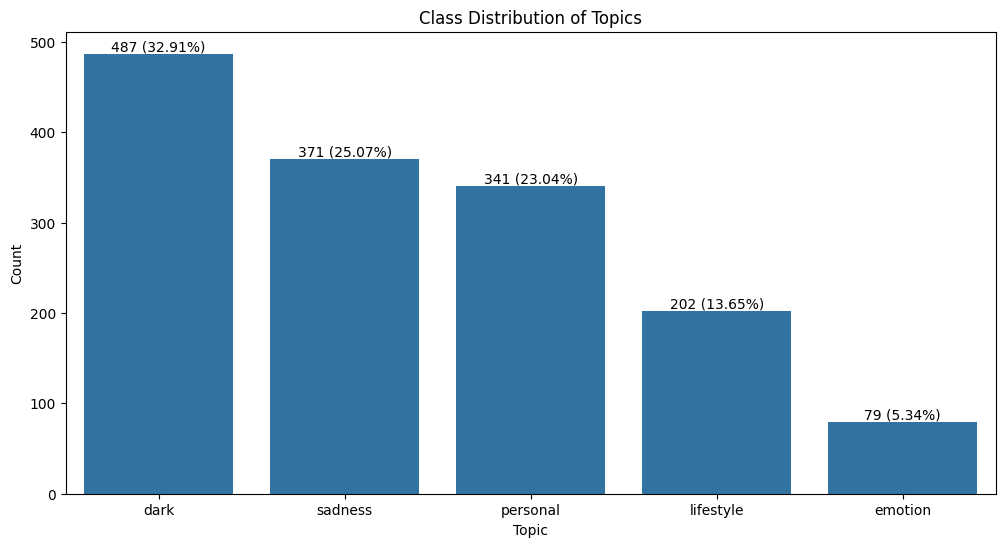

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

topic_counts = df["topic"].value_counts()
ax = sns.countplot(data=df, x="topic", order=topic_counts.index)

plt.title("Class Distribution of Topics")
plt.xlabel("Topic")
plt.ylabel("Count")

# Add total count on each bar
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = count / total * 100
    ax.annotate(f"{count} ({percentage:.2f}%)",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom")

plt.show()

The bar chart above shows that the dataset is not balanced:
- **dark**: 487 songs (32.91%)
- **sadness**: 371 songs (25.07%)
- **personal**: 341 songs (23.04%)
- **lifestyle**: 202 songs (13.65%)
- **emotion**: 79 songs (5.34%)

Given this class imbalance, we need to select evaluation metrics that provide insights into model performance across all classes, not just in general.

**Metrics chosen** (_*Part 1 Question 3_):
1. **Accuracy**: Measures the overall proportion of correctly classified songs across all topics, calculated as (True Positives + True Negatives) / Total Predictions. While accuracy can be misleading in imbalanced datasets (as a model could achieve high accuracy by predicting the overrepresented class), it still provides a baseline understanding of overall performance and can be used to compare multiple models.

2. **Macro-averaged Precision**: Precision measures "when my model predicts a song belongs to a specific topic, how often is it correct?". It's calculated as True Positives / (True Positives + False Positives). Macro-averaged precision calculates precision for each class separately and then takes the average. This treats all classes equally, regardless of frequency, making it appropriate for imbalanced datasets.

3. **Macro-averaged Recall**: Similar to macro-average precision, this calculates recall (True Positives / (True Positives + False Negatives) or "of all songs that actually belong to a topic, how many did my model correctly identify") for each class and averages them out. This is important for ensuring our model can identify songs from all topics, including underrepresented ones.

4. **Macro-averaged F1-score**: Provides a balanced measure between precision and recall for each class. This is useful because it penalises models that perform well on overrepresented classes but poor on underrepresented classes.

5. **Confusion Matrix**: A matrix showing exactly how the model performs for each topic pair. The diagonal shows correct predictions, while off-diagonal shows misclassifications. This helps us understand specific weaknesses and potential areas for improvement of the model.

**Why Macro-averaged over Micro-averaged Metrics?**

Macro-averaged metrics treat all classes equally, calculating the metrics for each class separately and then averaging them. This is better for our imbalanced dataset as micro-averaged metrics would be dominated by performance on the overrepresented classes (such as "dark").

__1.2.6. Model Training and Evaluation__

With our data preprocessed and vectorised, we can now build our classification models. Here we train both **Bernoulli Naive Bayes (BNB)** and **Multinomial Naive Bayes (MNB)** classifiers again with default settings (_*Part 1 Question 2_).

Usually we could use a single train-test split to assess our models, but this method can provide outcomes that rely on which specific samples are used in the training and test sets. Therefore, we use `StratifiedKFold`, which trains the models on multiple different splits, to get more reliable performance estimates than the single train-test split approach (_*Part 1 Question 1 and 3_).

In our implementation, we will:
| Step | Details |
|------|---------|
| **1** | Use `StratifiedKFold(n_splits=5, shuffle=True)` |
| **2** | For every fold:<br>• Train model on training data<br>• Predict on testing data<br>• Compute: Accuracy, Macro Precision, Macro Recall, Macro F1, Confusion Matrix |
| **3** | Averages out the scalar metrics across all folds (accuracy, precision, recall, F1 score) |
| **4** | Display an aggregated confusion matrix by summing all confusion matrices across all folds |

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

def train_evaluate_model(model, X, y, output=True):
    # Set up stratified k-fold cross-validation with 5 folds (n_splits=5)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialise lists to store evaluation metrics
    accuracies, precisions, recalls, f1_scores, confusion_matrices = [], [], [], [], []

    # Initialise aggregate confusion matrix
    n_classes = len(np.unique(y))
    aggregate_confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)

    # Train and evaluate model using stratified k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split data
        X_train, X_test = X[train_idx], X[val_idx]
        y_train, y_test = y[train_idx], y[val_idx]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on testing data
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average="macro", zero_division=0))
        recalls.append(recall_score(y_test, y_pred, average="macro", zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, average="macro", zero_division=0))
        matrix = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(matrix)

        # Add to aggregate confusion matrix
        aggregate_confusion_matrix += matrix

    result = {
        "accuracies": accuracies,
        "avg_accuracy": np.mean(accuracies),
        "precisions": precisions,
        "avg_precision": np.mean(precisions),
        "recalls": recalls,
        "avg_recall": np.mean(recalls),
        "f1_scores": f1_scores,
        "avg_f1_score": np.mean(f1_scores),
        "class_labels": sorted(np.unique(y)),
        "agg_confusion_matrix": aggregate_confusion_matrix
    }

    if not output:
        return model, result

    print(f"Evaluation metrics for {model.__class__.__name__}:")
    print(f"Classes: {result['class_labels']}")

    # Individual fold results
    print(f"\nPer-Fold Results:")
    print(f"Accuracies:        {[f'{acc:.4f}' for acc in result['accuracies']]}")
    print(f"Macro Precisions:  {[f'{prec:.4f}' for prec in result['precisions']]}")
    print(f"Macro Recalls:     {[f'{rec:.4f}' for rec in result['recalls']]}")
    print(f"Macro F1 Scores:   {[f'{f1:.4f}' for f1 in result['f1_scores']]}")

    # Summary statistics
    print(f"\nAverage Statistics:")
    print(f"Average Accuracy:   {result['avg_accuracy']:.4f}")
    print(f"Average Precision:  {result['avg_precision']:.4f}")
    print(f"Average Recall:     {result['avg_recall']:.4f}")
    print(f"Average F1 Score:   {result['avg_f1_score']:.4f}")

    # Confusion matrix
    print(f"\nAggregate Confusion Matrix:")
    print(result["agg_confusion_matrix"])

    return model, result

In [8]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb, bnb_result = train_evaluate_model(bnb, X, y)

Evaluation metrics for BernoulliNB:
Classes: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']

Per-Fold Results:
Accuracies:        ['0.5169', '0.5541', '0.5304', '0.4628', '0.4730']
Macro Precisions:  ['0.3846', '0.4706', '0.3977', '0.3044', '0.3811']
Macro Recalls:     ['0.3740', '0.4023', '0.3878', '0.3329', '0.3414']
Macro F1 Scores:   ['0.3343', '0.3634', '0.3535', '0.2933', '0.2985']

Average Statistics:
Average Accuracy:   0.5074
Average Precision:  0.3877
Average Recall:     0.3677
Average F1 Score:   0.3286

Aggregate Confusion Matrix:
[[341   5   8  24 109]
 [ 17   0   1   5  56]
 [ 48   0   4  14 136]
 [ 87   1   2 101 150]
 [ 56   0   1   9 305]]


In [9]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb, mnb_result = train_evaluate_model(mnb, X, y)

Evaluation metrics for MultinomialNB:
Classes: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']

Per-Fold Results:
Accuracies:        ['0.7939', '0.7804', '0.7939', '0.7939', '0.7365']
Macro Precisions:  ['0.7382', '0.7103', '0.7254', '0.7490', '0.6620']
Macro Recalls:     ['0.7068', '0.6708', '0.7117', '0.7130', '0.6254']
Macro F1 Scores:   ['0.7163', '0.6800', '0.7165', '0.7269', '0.6313']

Average Statistics:
Average Accuracy:   0.7797
Average Precision:  0.7170
Average Recall:     0.6856
Average F1 Score:   0.6942

Aggregate Confusion Matrix:
[[393  17   9  25  43]
 [ 12  19  12  12  24]
 [ 20   3 140  11  28]
 [ 29   6   5 280  21]
 [ 26   3   5  15 322]]


__1.2.7. Preprocessing Refinement__

While initial preprocessing (e.g., stopword removal, stemming) provides a solid foundation, its efficiency varies depending on how much linguistic structure is preserved or lost. Therefore, in order to improve the preprocessing pipeline and see how it affects our classifiers (BNB and MNB) performance, we define a function `build_preprocessor` that builds preprocessing pipelines based on set of interchangeable paramaters/toggles that allow us to easily compare and experiment with multiple preprocessing strategies.

As required by the assignment, we keep the use of `CountVectorizer` with its default settings, but we change the way text is preprocessed before vectorisation. Each variations of preprocessing will also be tested using the same BNB and MNB classifier with the same default settings as before to ensure fair comparison.

In [10]:
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")

def build_preprocessor(
    lowercase=True,
    remove_numbers=True,
    expand_contractions=True,
    remove_punctuations=True,
    remove_stopwords=True,
    stem_words=True,
    lemmatize_words=False,
    pos_tagging=False,
):
    def preprocess_text(text):
        # Convert text to lowercase
        if lowercase:
            text = text.lower()

        # Remove numbers
        if remove_numbers:
            text = re.sub(r"\d+", "", text)

        # Expand contractions
        if expand_contractions:
            text = contractions.fix(text)
            text = re.sub(r"-", " ", text)
            text = re.sub(r"[^\w\s]", " ", text, flags=re.UNICODE)

        # Remove all punctuations
        if remove_punctuations:
            text = re.sub(r"[^\w\s]", "", text, flags=re.UNICODE)
            text = re.sub(r"-", " ", text)

        # Normalise whitespace
        text = re.sub(r"\s+", " ", text).strip()

        # Tokenisation
        tokens = word_tokenize(text)

        # Remove stopwords
        if remove_stopwords:
            stop_words = set(stopwords.words())
            tokens = [word for word in tokens if word not in stop_words]

        # Lemmatization
        if lemmatize_words:
            wnl = WordNetLemmatizer()
            tokens = [wnl.lemmatize(word) for word in tokens]

        # Stemming
        if stem_words:
            ps = PorterStemmer()
            tokens = [ps.stem(word) for word in tokens]

        # POS tagging
        if pos_tagging:
            pos_tags = nltk.pos_tag(tokens)
            tokens = [f"{word}_{tag}" for word, tag in pos_tags]

        return " ".join(tokens)

    return preprocess_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/merryrosalie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/merryrosalie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/merryrosalie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/merryrosalie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess documents
preprocessor = build_preprocessor(
    lowercase=True,
    remove_numbers=True,
    expand_contractions=False,
    remove_punctuations=True,
    remove_stopwords=False,
    stem_words=True,
    lemmatize_words=True,
    pos_tagging=False,
)

# Apply preprocessing to the dataframe
df["processed_text"] = df["combined_text"].apply(preprocessor)

# Vectorisation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["processed_text"])
y = np.array(df["topic"]) # target labels

In [12]:
from sklearn.naive_bayes import BernoulliNB

# Train and evaluate models
bnb = BernoulliNB()
prev_bnb_result = bnb_result
bnb, bnb_result = train_evaluate_model(bnb, X, y, output=False)

In [13]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
prev_mnb_result = mnb_result
mnb, mnb_result = train_evaluate_model(mnb, X, y, output=False)

**Refined Preprocessing Pipeline**

After experimenting with all the parameters/components of the preprocessing pipeline, the best performing preprocessing pipeline is:

```python
preprocessor = build_preprocessor(
    lowercase=True,            # Standardise capitalisation
    remove_numbers=True,       # Eliminate numeric noise
    expand_contractions=False, # Preserve contraction style
    remove_punctuations=True,  # Remove formatting noise
    remove_stopwords=False,    # Keep stopwords
    stem_words=True,           # Apply stemming
    lemmatize_words=True,      # Apply lemmatisation
    pos_tagging=False,         # Avoid POS tagging
)
```

This preprocessing pipeline is justified as it achieved the highest overall accuracy, macro precision, macro recall, and macro F1 score compared to other variations (_*Part 1 Question 2_).

In [14]:
print("PREPROCESSING PIPELINE COMPARISON (BEFORE VS AFTER):")
comparison_table = {
    "Metrics": ["Average Accuracy", "Average Precision", "Average Recall", "Average F1 Score"],
    "Before (BNB)": [prev_bnb_result["avg_accuracy"], prev_bnb_result["avg_precision"],
                     prev_bnb_result["avg_recall"], prev_bnb_result["avg_f1_score"]],
    "After (BNB)": [bnb_result["avg_accuracy"], bnb_result["avg_precision"],
                    bnb_result["avg_recall"], bnb_result["avg_f1_score"]],
    "Before (MNB)": [prev_mnb_result["avg_accuracy"], prev_mnb_result["avg_precision"],
                     prev_mnb_result["avg_recall"], prev_mnb_result["avg_f1_score"]],
    "After (MNB)": [mnb_result["avg_accuracy"], mnb_result["avg_precision"],
                    mnb_result["avg_recall"], mnb_result["avg_f1_score"]],
}
comparison_table_df = pd.DataFrame(comparison_table)
print(comparison_table_df.to_string(index=False))

PREPROCESSING PIPELINE COMPARISON (BEFORE VS AFTER):
          Metrics  Before (BNB)  After (BNB)  Before (MNB)  After (MNB)
 Average Accuracy      0.507432     0.531757      0.779730     0.792568
Average Precision      0.387690     0.404698      0.716974     0.752014
   Average Recall      0.367691     0.384317      0.685558     0.711628
 Average F1 Score      0.328590     0.344698      0.694212     0.723366


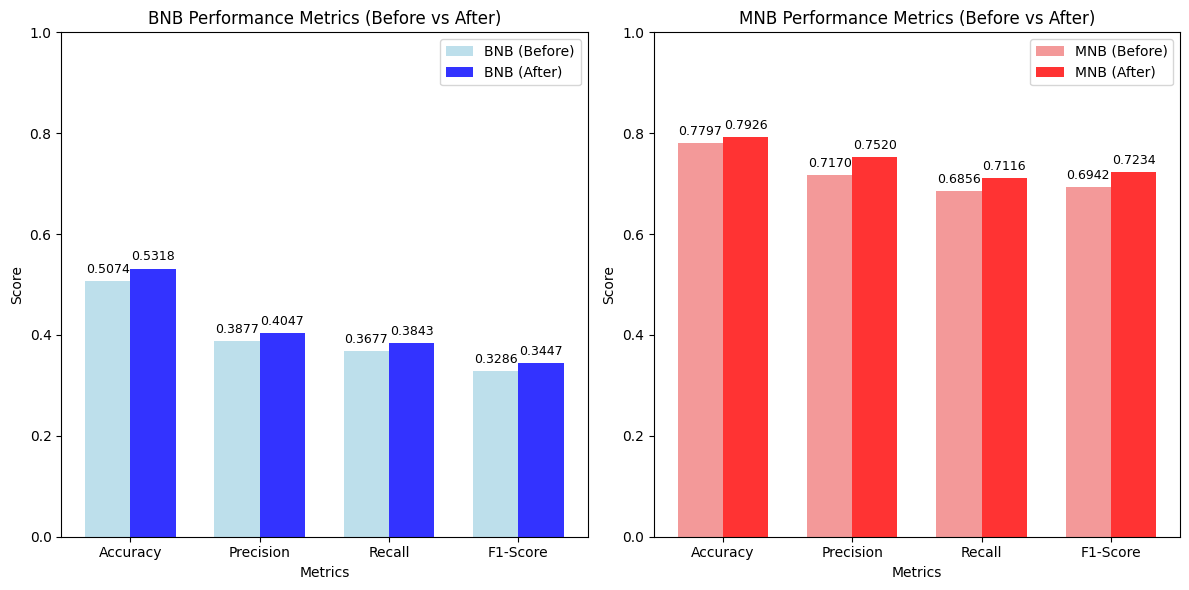

In [15]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

# 1. BNB Performance Metrics (Before vs After)
plt.subplot(1, 2, 1)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
bnb_before = [prev_bnb_result["avg_accuracy"], prev_bnb_result["avg_precision"],
              prev_bnb_result["avg_recall"], prev_bnb_result["avg_f1_score"]]
bnb_after = [bnb_result["avg_accuracy"], bnb_result["avg_precision"],
             bnb_result["avg_recall"], bnb_result["avg_f1_score"]]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width / 2, bnb_before, width, label="BNB (Before)", alpha=0.8, color="lightblue")
plt.bar(x + width / 2, bnb_after, width, label="BNB (After)", alpha=0.8, color="blue")

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("BNB Performance Metrics (Before vs After)")
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
for i, (bnb_before_val, bnb_after_val) in enumerate(zip(bnb_before, bnb_after)):
    plt.text(i - width / 2, bnb_before_val + 0.01, f"{bnb_before_val:.4f}", ha="center", va="bottom", fontsize=9)
    plt.text(i + width / 2, bnb_after_val + 0.01, f"{bnb_after_val:.4f}", ha="center", va="bottom", fontsize=9)

# 2. MNB Performance Metrics (Before vs After)
plt.subplot(1, 2, 2)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
mnb_before = [prev_mnb_result["avg_accuracy"], prev_mnb_result["avg_precision"],
              prev_mnb_result["avg_recall"], prev_mnb_result["avg_f1_score"]]
mnb_after = [mnb_result["avg_accuracy"], mnb_result["avg_precision"],
             mnb_result["avg_recall"], mnb_result["avg_f1_score"]]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width / 2, mnb_before, width, label="MNB (Before)", alpha=0.8, color="lightcoral")
plt.bar(x + width / 2, mnb_after, width, label="MNB (After)", alpha=0.8, color="red")

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("MNB Performance Metrics (Before vs After)")
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
for i, (mnb_before_val, mnb_after_val) in enumerate(zip(mnb_before, mnb_after)):
    plt.text(i - width / 2, mnb_before_val + 0.01, f"{mnb_before_val:.4f}", ha="center", va="bottom", fontsize=9)
    plt.text(i + width / 2, mnb_after_val + 0.01, f"{mnb_after_val:.4f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

Initially, I hypothesised that a "cleaner" pipeline using lemmatisation or stemming separately, removing stopwords, and expanding contractions would improve performance by providing more semantically correct input for classification. However, the results showed a different pattern:
- Lemmatisation and stemming together produced stronger generalisation than either method alone by combining grammatical and inflectional variances.
- Removing stopwords and expanding contractions unexpectedly hurt performance since lyrics' use of pronouns and negations conveyed emotion or context related to the theme and maintains personal expression markers.

As we have found the best preprocessing pipeline, the preprocessor with the following steps will be used consistently throughout the rest of the assignment (_*Part 1 Question 2_):
1. **Lowercasing**: Standardises text capitalisation to lowercase
2. **Number Removal**: Filters out numeric content that typically becomes noise in song lyrics
3. **Contraction Preservation**: Maintains informal language style characteristic of song lyrics
4. **Punctuation Removal**: Eliminates punctuations noise while keeping semantic content
5. **Preserving Stopwords**: Preserves pronouns and function words important for emotional expression
6. **Using Both Stemming and Lemmatisation**: Uses both stemming and lemmatisation for stronger generalisation

__1.2.8. Comparison of BNB and MNB__

PER-CLASS PERFORMANCE COMPARISON:
    Class BNB Precision MNB Precision BNB Recall MNB Recall BNB F1 MNB F1
     dark        0.4014        0.7745     0.3908     0.7164 0.3516 0.7346
  emotion        0.4629        0.7384     0.4012     0.7008 0.3639 0.7097
lifestyle        0.3891        0.7553     0.3897     0.7321 0.3527 0.7409
 personal        0.3360        0.7737     0.3684     0.7431 0.3264 0.7550
  sadness        0.4340        0.7181     0.3716     0.6659 0.3288 0.6766


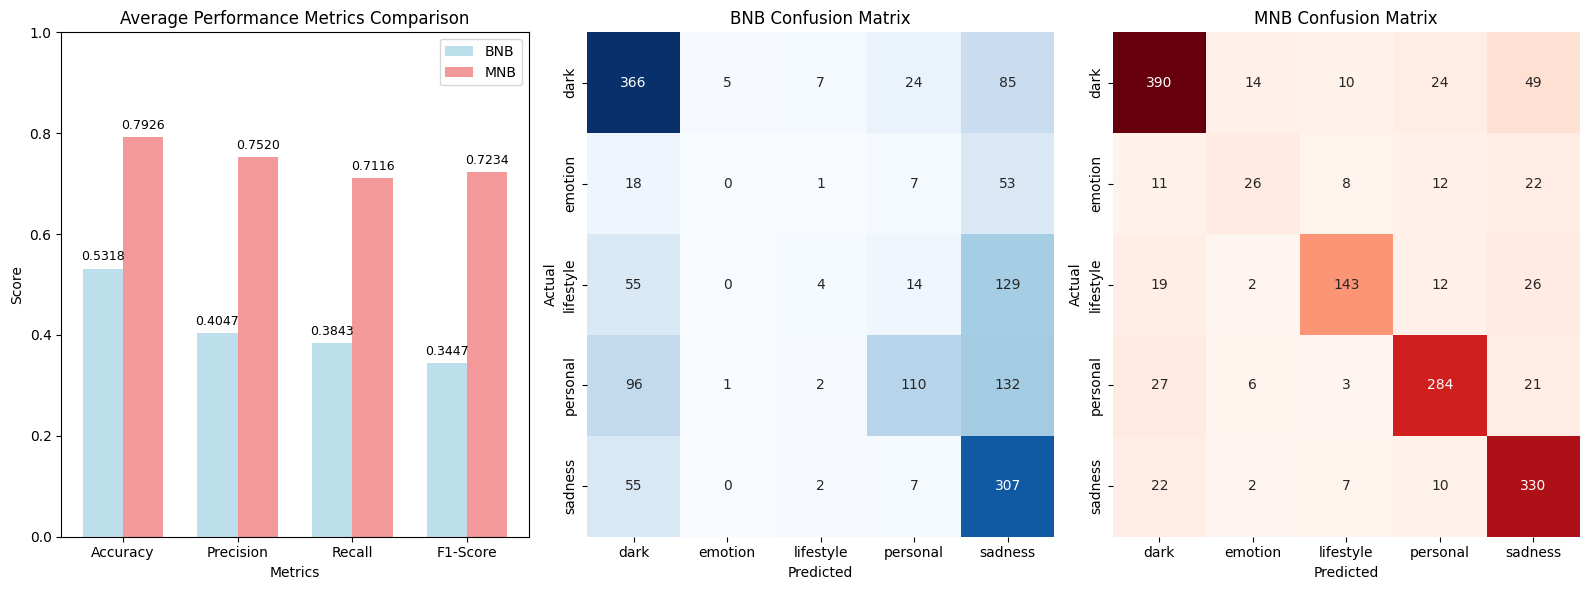

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Per-class performance table
print("PER-CLASS PERFORMANCE COMPARISON:")
per_class_data = {
    "Class": bnb_result["class_labels"],
    "BNB Precision": [f"{score:.4f}" for score in bnb_result["precisions"]],
    "MNB Precision": [f"{score:.4f}" for score in mnb_result["precisions"]],
    "BNB Recall": [f"{score:.4f}" for score in bnb_result["recalls"]],
    "MNB Recall": [f"{score:.4f}" for score in mnb_result["recalls"]],
    "BNB F1": [f"{score:.4f}" for score in bnb_result["f1_scores"]],
    "MNB F1": [f"{score:.4f}" for score in mnb_result["f1_scores"]]
}
per_class_df = pd.DataFrame(per_class_data)
print(per_class_df.to_string(index=False))

class_labels = bnb_result["class_labels"]

# Create plots
fig = plt.figure(figsize=(16, 6))

# 1. Performance Metrics Comparison (Bar Chart)
plt.subplot(1, 3, 1)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
bnb_avg = [bnb_result["avg_accuracy"], bnb_result["avg_precision"],
           bnb_result["avg_recall"], bnb_result["avg_f1_score"]]
mnb_avg = [mnb_result["avg_accuracy"], mnb_result["avg_precision"],
           mnb_result["avg_recall"], mnb_result["avg_f1_score"]]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width / 2, bnb_avg, width, label="BNB", alpha=0.8, color="lightblue")
plt.bar(x + width / 2, mnb_avg, width, label="MNB", alpha=0.8, color="lightcoral")

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Average Performance Metrics Comparison")
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
for i, (bnb_val, mnb_val) in enumerate(zip(bnb_avg, mnb_avg)):
    plt.text(i - width / 2, bnb_val + 0.01, f"{bnb_val:.4f}", ha="center", va="bottom", fontsize=9)
    plt.text(i + width / 2, mnb_val + 0.01, f"{mnb_val:.4f}", ha="center", va="bottom", fontsize=9)

# 2. Confusion Matrix for BNB
plt.subplot(1, 3, 2)
sns.heatmap(bnb_result["agg_confusion_matrix"], annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title("BNB Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 3. Confusion Matrix for MNB
plt.subplot(1, 3, 3)
sns.heatmap(mnb_result["agg_confusion_matrix"], annot=True, fmt="d", cmap="Reds",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title("MNB Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

**Performance Metrics Comparison Bar Chart Analysis**

Evaluating the performance metrics comparison bar chart, MNB clearly outperforms BNB in all evaluation metrics, with 79.26% accuracy vs 53.18%, macro precision of 75.2% vs 40.47%, macro recall of 71.16% vs 38.43%, and macro F1-score of 72.34% vs 34.47%.

**Confusion Matrix Analysis**

BNB confusion matrix shows a lot of shortcomings, most notably its performance with underrepresented class (e.g., 0 true positives out of 79 cases for "emotion", and 4 true positives out of 202 cases for "lifestyle"). In contrast, MNB's confusion matrix shows a much more balanced performance across all five topics, even with stronger performance on underrepresented classes: correctly classifying 26 out of 79 "emotion" songs and 143 out of 202 "lifestyle" songs.

**Per-Class Performance Analysis**

The per-class metrics further highlights MNB's superiority. For the "emotion" class, MNB obtains a precision of 0.7384 and recall of 0.7008, however BNB is significantly lower (0.4629 precision and 0.4012 recall), even though "emotion" is one of the class where BNB does well.

**Theoretical Justifications**

The greater performance of MNB actually can be explained by the algorithmic differences that better fit the topic classification task. MNB is well suited for capturing the frequency data from `CountVectorizer`. In contrast, BNB focuses more on whether words appear rather than how often they appear. For song's topic classification, word frequency may be more informative than simple word presence, as the repetition and emphasis of certain terms could be key indicators of lyrical themes or topics.

**Conclusion**

**MNB clearly outperforms BNB** in our topic classification task, with superior performance across all metrics, better handling of class imbalance, and theoretical appropriateness for frequency-based features (_*Part 1 Question 3_).

#### 1.3. Varying Number of Features

In this section, we will look at how the number of features affects the performance of our topic classification models (BNB and MNB). By experimenting with different values of N, we aim to find a balance between model complexity and performance (_*Part 1 Question 4_) as too few features would lead us to miss important words, while too many features could lead to noise and overfitting.

To do this, we will experiment with different values of N to pass to the `max_features` parameter in `CountVectorizer`, which limits the vocabulary to the top N most frequent words.

During testing, I tested with an initial set of feature counts:

```python
n_features = [100, 500, 750, 1000, 5000, 10000, None]  # None = all features
```

I observed that both BNB and MNB showed performance improvement in the range of 500 to 750 features. Specifically, both MNB and BNB achieved its best results around 500, while BNB slightly improved at 750 but MNB degraded beyond that.

To further test the optimal range, I tested additional values around the range 500 - 750:

```python
n_features = [500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750]
```

Then I found that both models improved at around 550 - 575, so I tested more values:
```python
n_features = [550, 555, 560, 565, 570, 575]
```

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Define range of feature counts to test
n_features = [100, 500, 550, 575, 750, 1000, 5000, None] # None = all features

# Store results for both models
bnb_results = []
mnb_results = []
feature_labels = []

for n in n_features:
    # Create vectoriser with specific number of features
    vectorizer = CountVectorizer(max_features=n)
    test_X = vectorizer.fit_transform(df["processed_text"])

    # Train and evaluate BNB
    bnb_model = BernoulliNB()
    _, bnb_result = train_evaluate_model(bnb_model, test_X, y, output=False)
    bnb_results.append(bnb_result)

    # Train and evaluate MNB
    mnb_model = MultinomialNB()
    _, mnb_result = train_evaluate_model(mnb_model, test_X, y, output=False)
    mnb_results.append(mnb_result)

    # Store actual feature count for plotting
    actual_features = test_X.shape[1]
    feature_labels.append(f"{actual_features}")

In [18]:
import pandas as pd

# Extract metrics for tables and plots
bnb_accuracies = [result["avg_accuracy"] for result in bnb_results]
bnb_precisions = [result["avg_precision"] for result in bnb_results]
bnb_recalls = [result["avg_recall"] for result in bnb_results]
bnb_f1_scores = [result["avg_f1_score"] for result in bnb_results]

mnb_accuracies = [result["avg_accuracy"] for result in mnb_results]
mnb_precisions = [result["avg_precision"] for result in mnb_results]
mnb_recalls = [result["avg_recall"] for result in mnb_results]
mnb_f1_scores = [result["avg_f1_score"] for result in mnb_results]

# Display detailed results table
print("DETAILED RESULTS TABLE:")
result_table = {
    "Features": feature_labels,
    "BNB Accuracy": [f"{score:.4f}" for score in bnb_accuracies],
    "MNB Accuracy": [f"{score:.4f}" for score in mnb_accuracies],
    "BNB Precision": [f"{score:.4f}" for score in bnb_precisions],
    "MNB Precision": [f"{score:.4f}" for score in mnb_precisions],
    "BNB Recall": [f"{score:.4f}" for score in bnb_recalls],
    "MNB Recall": [f"{score:.4f}" for score in mnb_recalls],
    "BNB F1": [f"{score:.4f}" for score in bnb_f1_scores],
    "MNB F1": [f"{score:.4f}" for score in mnb_f1_scores]
}
result_table_df = pd.DataFrame(result_table)
print(result_table_df.to_string(index=False))

DETAILED RESULTS TABLE:
Features BNB Accuracy MNB Accuracy BNB Precision MNB Precision BNB Recall MNB Recall BNB F1 MNB F1
     100       0.5905       0.7635        0.5325        0.7386     0.5059     0.7488 0.5127 0.7412
     500       0.6378       0.8662        0.5364        0.8445     0.5354     0.8378 0.5334 0.8392
     550       0.6432       0.8662        0.5480        0.8457     0.5440     0.8393 0.5431 0.8406
     575       0.6507       0.8608        0.5584        0.8433     0.5498     0.8358 0.5499 0.8375
     750       0.6392       0.8547        0.5493        0.8425     0.5319     0.8289 0.5316 0.8329
    1000       0.6338       0.8412        0.5479        0.8279     0.5267     0.8170 0.5266 0.8203
    5000       0.5615       0.8041        0.4830        0.7671     0.4211     0.7542 0.3994 0.7575
    8924       0.5318       0.7926        0.4047        0.7520     0.3843     0.7116 0.3447 0.7234


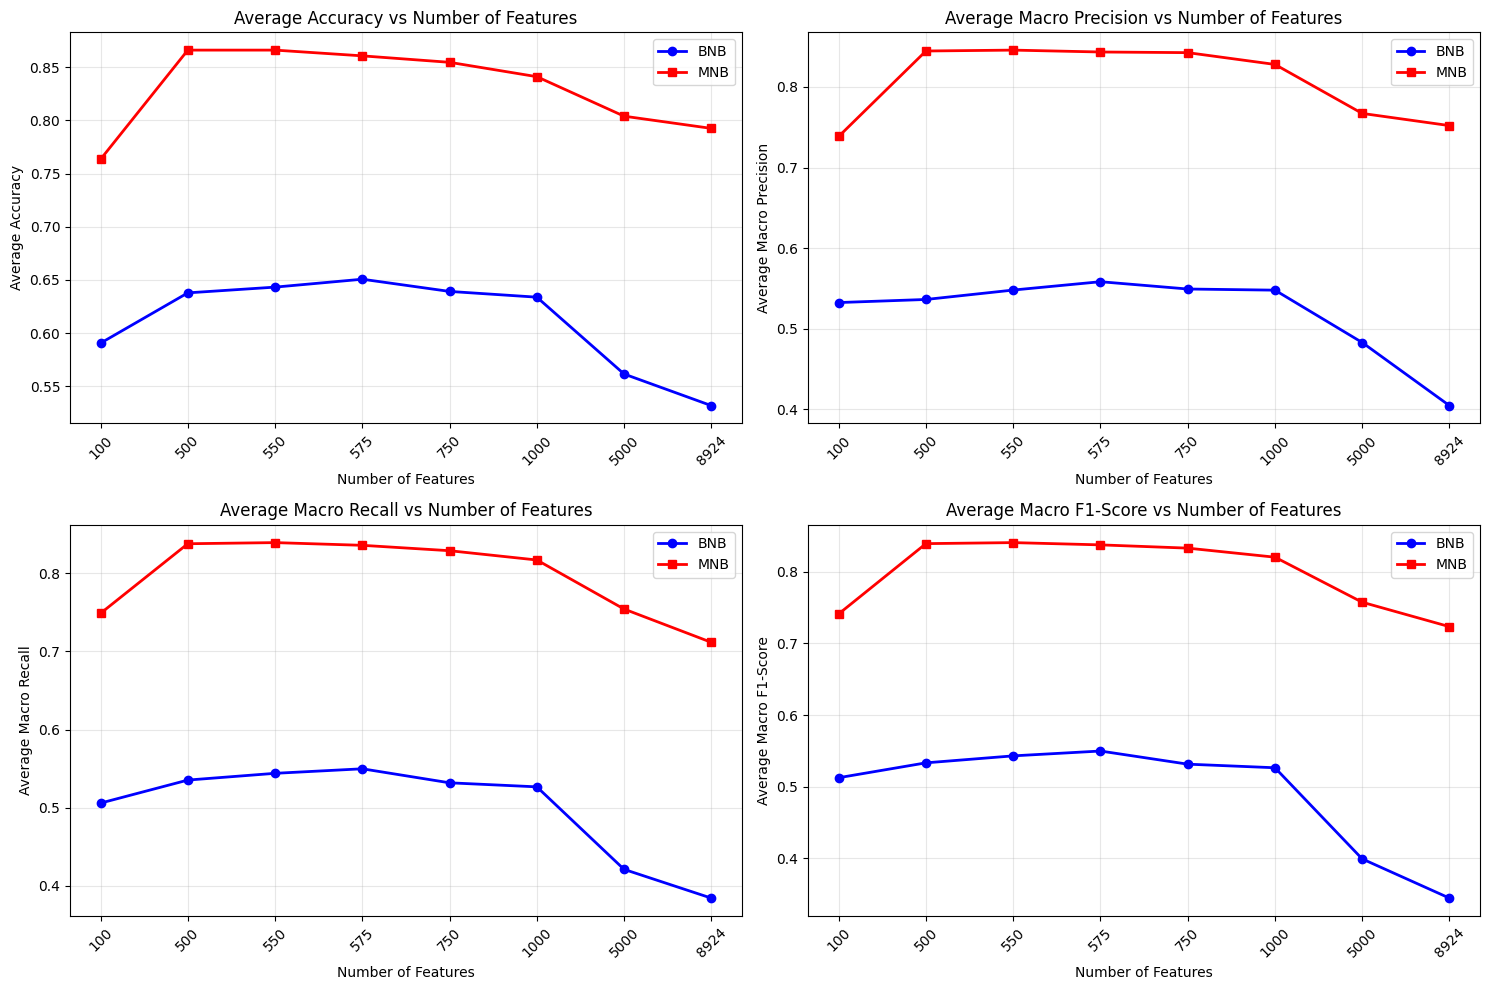

In [19]:
import matplotlib.pyplot as plt

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Accuracy comparison
ax1.plot(range(len(feature_labels)), bnb_accuracies, "o-", label="BNB", color="blue", linewidth=2, markersize=6)
ax1.plot(range(len(feature_labels)), mnb_accuracies, "s-", label="MNB", color="red", linewidth=2, markersize=6)
ax1.set_xlabel("Number of Features")
ax1.set_ylabel("Average Accuracy")
ax1.set_title("Average Accuracy vs Number of Features")
ax1.set_xticks(range(len(feature_labels)))
ax1.set_xticklabels(feature_labels, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Precision comparison
ax2.plot(range(len(feature_labels)), bnb_precisions, "o-", label="BNB", color="blue", linewidth=2, markersize=6)
ax2.plot(range(len(feature_labels)), mnb_precisions, "s-", label="MNB", color="red", linewidth=2, markersize=6)
ax2.set_xlabel("Number of Features")
ax2.set_ylabel("Average Macro Precision")
ax2.set_title("Average Macro Precision vs Number of Features")
ax2.set_xticks(range(len(feature_labels)))
ax2.set_xticklabels(feature_labels, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Recall comparison
ax3.plot(range(len(feature_labels)), bnb_recalls, "o-", label="BNB", color="blue", linewidth=2, markersize=6)
ax3.plot(range(len(feature_labels)), mnb_recalls, "s-", label="MNB", color="red", linewidth=2, markersize=6)
ax3.set_xlabel("Number of Features")
ax3.set_ylabel("Average Macro Recall")
ax3.set_title("Average Macro Recall vs Number of Features")
ax3.set_xticks(range(len(feature_labels)))
ax3.set_xticklabels(feature_labels, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: F1-Score comparison
ax4.plot(range(len(feature_labels)), bnb_f1_scores, "o-", label="BNB", color="blue", linewidth=2, markersize=6)
ax4.plot(range(len(feature_labels)), mnb_f1_scores, "s-", label="MNB", color="red", linewidth=2, markersize=6)
ax4.set_xlabel("Number of Features")
ax4.set_ylabel("Average Macro F1-Score")
ax4.set_title("Average Macro F1-Score vs Number of Features")
ax4.set_xticks(range(len(feature_labels)))
ax4.set_xticklabels(feature_labels, rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

From these results, I found that both models peaked at **550 features**, achieving the best balance across accuracy, precision, recall, and F1-score (_*Part 1 Question 4_). Beyond 550 features, MNB starts to degrade while BNB continued to improve but the gains were small and came at the cost of consistency.

**Updated BNB and MNB models**

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorisation with new N number of Features
N = 550 # Optimal number of features
vectorizer = CountVectorizer(max_features=N)

# Update with new vectoriser
X = vectorizer.fit_transform(df["processed_text"]) # df["processed_text"] is previously preprocessed
y = np.array(df["topic"]) # target labels

In [21]:
from sklearn.naive_bayes import BernoulliNB

# Train and evaluate BNB model with updated vectorisation
bnb = BernoulliNB()
bnb, bnb_result = train_evaluate_model(bnb, X, y, output=False)

In [22]:
from sklearn.naive_bayes import MultinomialNB

# Train and evaluate MNB model with updated vectorisation
mnb = MultinomialNB()
mnb, mnb_result = train_evaluate_model(mnb, X, y, output=False)

#### 1.4. Alternative Classification Model

__1.4.1. Evaluation of Different Classification Models__

Before deciding on one alternative classification model, let's evaluate all models discussed in the lecture for their suitability to our song topic classification task:

- **Support Vector Machines (SVM)**: SVM works by finding a globally optimal decision boundaries, and it can handle high-dimensional sparse features and multi-class problems. However, unless the `class_weight` parameter is changed, SVM may be sensitive to the class imbalance in our datasets.
- **K-Nearest Neighbours (KNN)**: When dealing with high-dimensional data, KNN performs pretty poorly due to the curse of dimensionality. The sparse nature of these vectors makes distance calculations less reliable, and KNN slows down when data is large.
- **Decision Tree**: Decision tree is likely to overfit with sparse data, because it may learn to rely on specific word combinations that don't represent patterns for a topic, leading to poor generalisation. Without proper limits on tree depth or minimum samples per split, the model will likely perform poorly.
- **Random Forest**: Random forest combines many decision trees to address concerns that would otherwise arise with a single decision tree. Furthermore, by training each tree on separate subsets of data and features, Random Forest can reduce overfitting while maintaining good performance.

Both SVM and Random Forest are strong candidates for this song topic classification task. While Random Forest can offer ensemble robustness (more robust by default), SVM can typically outperform it when class imbalance is addressed using `class_weight="balanced"`. With high-dimensional sparse features, SVM's ability to handle such feature spaces and identify globally optimal decision boundaries provides it an advantage over Random Forest. Furthermore, unlike BNB and MNB, SVM may learn more complex decision boundaries without assuming probability distributions for word frequencies. However, for SVM to work effectively, `TfidfVectorizer` should be used, as it weights terms by their importance across the corpus, helping SVM better distinguish between common and distinctive terms when finding optimal decision boundaries. For these reasons, **SVM has the potential to outperform BNB and MNB models, thus is selected as the alternative classification model** (_*Part 1 Question 5_).

__1.4.2. Implementation__

For our SVM implementation, we will use the same preprocessing as applied to our BNB and MNB models. However, a different vectorizer `TfidfVectorizer` will be used to help SVM better distinguish between common and distinctive terms when finding optimal decision boundaries.

The SVM model will be implemented using sklearn's `SVC` classifier with the following configuration (_*Part 1 Question 5_):
- `class_weight="balanced"`: This parameter automatically adjusts weights inversely proportional to class frequencies, addressing the class imbalance in our dataset.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

tfidf_vectorizer = TfidfVectorizer(max_features=N)

# Update with TF-IDF vectoriser
svm_X = tfidf_vectorizer.fit_transform(df["processed_text"]) # df["processed_text"] is previously preprocessed
svm_y = np.array(df["topic"]) # target labels

svm = SVC(class_weight="balanced")
svm, svm_result = train_evaluate_model(svm, svm_X, svm_y)

Evaluation metrics for SVC:
Classes: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']

Per-Fold Results:
Accuracies:        ['0.9122', '0.8986', '0.8953', '0.8750', '0.8480']
Macro Precisions:  ['0.9139', '0.8943', '0.9180', '0.8813', '0.8709']
Macro Recalls:     ['0.8734', '0.8719', '0.9050', '0.8347', '0.8290']
Macro F1 Scores:   ['0.8912', '0.8822', '0.9085', '0.8539', '0.8464']

Average Statistics:
Average Accuracy:   0.8858
Average Precision:  0.8957
Average Recall:     0.8628
Average F1 Score:   0.8764

Aggregate Confusion Matrix:
[[453   5   5  12  12]
 [ 11  61   2   1   4]
 [ 19   1 174   2   6]
 [ 32   0   5 300   4]
 [ 34   2   6   6 323]]


#### 1.5. Conclusion

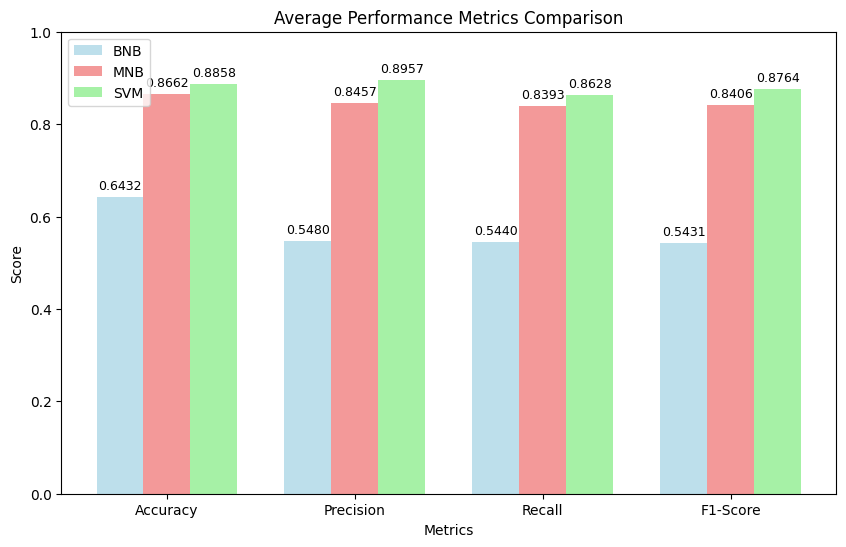

In [24]:
import numpy as np
import matplotlib.pyplot as plt

class_labels = bnb_result["class_labels"]

# Create plots
plt.figure(figsize=(10, 6))

# Performance Metrics Comparison (Bar Chart)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
bnb_avg = [bnb_result["avg_accuracy"], bnb_result["avg_precision"],
           bnb_result["avg_recall"], bnb_result["avg_f1_score"]]
mnb_avg = [mnb_result["avg_accuracy"], mnb_result["avg_precision"],
           mnb_result["avg_recall"], mnb_result["avg_f1_score"]]
svm_avg = [svm_result["avg_accuracy"], svm_result["avg_precision"],
           svm_result["avg_recall"], svm_result["avg_f1_score"]]

x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, bnb_avg, width, label="BNB", alpha=0.8, color="lightblue")
plt.bar(x, mnb_avg, width, label="MNB", alpha=0.8, color="lightcoral")
plt.bar(x + width, svm_avg, width, label="SVM", alpha=0.8, color="lightgreen")

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Average Performance Metrics Comparison")
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
for i, (bnb_val, mnb_val, svm_val) in enumerate(zip(bnb_avg, mnb_avg, svm_avg)):
    plt.text(i - width, bnb_val + 0.01, f"{bnb_val:.4f}", ha="center", va="bottom", fontsize=9)
    plt.text(i, mnb_val + 0.01, f"{mnb_val:.4f}", ha="center", va="bottom", fontsize=9)
    plt.text(i + width, svm_val + 0.01, f"{svm_val:.4f}", ha="center", va="bottom", fontsize=9)

plt.show()

The results confirm the initial hypothesis, showing that **SVM with `TfidfVectorizer` outperforms both BNB and MNB** across all evaluation metrics: accuracy, macro precision, macro recall and macro f1 score.

This result can be attributed to the combination of the strengths of SVM algorithmic strengths with `TfidfVectorizer`'s feature representation. Unlike `CountVectorizer` which produces frequency counts, `TfidfVectorizer` weights terms by their distinctiveness across the corpus. This weighting approach helps SVM identify more meaningful decision boundaries by emphasising distinctive terms while downweighting common words that appear frequently across all topics. Additionally, SVM's ability to learn non-linear decision boundaries, combined with its robustness to high-dimensional sparse data, makes it particularly well-suited for song topic classification task where topics may have subtle linguistic distinctions.

In conclusion, **SVM with `TfidfVectorizer`** is the **best choice** for our song's topic classification task (_*Part 1 Question 5_). This findings will later inform the implementation of the recommender system.

### Part 2 - Recommendation Methods

### 2.1. Introduction

Building upon the topic classification model developed in Part 1, we now move on to the main functionality of our content-based recommendation system. The recommendation system is responsible for matching songs with different user profiles.

**Goals:**

1. Create separate TF-IDF matrices for each of the 5 topics using training songs predicted by the classifier from Part 1.
2. Build user profiles for three different users (User 1, User 2, and a hypothetical User 3) by integrating songs they "like" within each topic into topic-specific TF-IDF vectors that capture their preferences.
3. Implement and compare different similarity matching algorithms (such as cosine similarity, Euclidean distance, or Jaccard similarity) to find which method most effectively identifies songs that align with user preferences.
4. Experiment and evaluate hyperparameters, such as the number of recommendations (N) and the number of top words in user profiles (M).
5. Evaluate recommendations with appropriate metrics that balance precision, recall, and user satisfaction to ensure that the system produces relevant and diverse recommendations.

### 2.2. Data Preparation

__2.2.1. Training-Test Split__

Following the assignment specification, we split our dataset into training (songs 1 - 750) and test (songs 751 - 1000) data sets, representing data from Week 1 - 3 and Week 4 respectively (_*Part 2 Question 1_). This simulates a realistic scenario where a recommendation system learns from historical user interactions and then predicts new songs.

In [25]:
# Split the dataset
train_df = df.iloc[:750].copy()  # First 750 songs (Weeks 1-3)
test_df = df.iloc[750:1000].copy()  # Next 250 songs (Week 4)

print(f"Training set shape: {train_df.shape}")
print(f"Topic distribution in training set:")
actual_training_counts = train_df["topic"].value_counts().sort_index()
print(actual_training_counts)

print(f"\nTest set shape: {test_df.shape}")
print(f"Topic distribution in test set:")
actual_testing_counts = test_df["topic"].value_counts().sort_index()
print(actual_testing_counts)

Training set shape: (750, 8)
Topic distribution in training set:
dark         246
emotion       42
lifestyle     92
personal     187
sadness      183
Name: topic, dtype: int64

Test set shape: (250, 8)
Topic distribution in test set:
dark         83
emotion      15
lifestyle    33
personal     49
sadness      70
Name: topic, dtype: int64


__2.2.2. Applying Topic Classification__

Then, we use our best-performing classifier (SVM with `TfidfVectorizer` and 550 features) from Part 1 to predict topics for both training and test songs (_*Part 2 Question 1_). This simulates a realistic scenario where the recommendation system only has access to predicted topics, not true labels.

In [26]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Use the same preprocessing pipeline from Part 1
preprocessor = build_preprocessor(
    lowercase=True,
    remove_numbers=True,
    expand_contractions=False,
    remove_punctuations=True,
    remove_stopwords=False,
    stem_words=True,
    lemmatize_words=True,
    pos_tagging=False,
)

# Preprocess all documents
train_df["processed_text"] = train_df["combined_text"].apply(preprocessor)
test_df["processed_text"] = test_df["combined_text"].apply(preprocessor)

# Use the same vectoriser with 550 features (optimal N) from Part 1
N = 550
vectorizer = TfidfVectorizer(max_features=N)
X_train = vectorizer.fit_transform(train_df["processed_text"])
X_test = vectorizer.transform(test_df["processed_text"])

y_train = np.array(train_df["topic"])

# Train the SVM classifier on training data
svm = SVC(class_weight="balanced")
svm, svm_result = train_evaluate_model(svm, X_train, y_train, output=False)

# Predict topics for both training and test data
train_df["predicted_topic"] = svm.predict(X_train)
test_df["predicted_topic"] = svm.predict(X_test)

print(f"Topic Distribution in training set (Actual vs Predicted):")
predicted_training_counts = train_df["predicted_topic"].value_counts().sort_index()
train_distribution_df = pd.DataFrame({
    "Actual": actual_training_counts,
    "Predicted": predicted_training_counts
})
print(train_distribution_df)

print(f"\nTopic Distribution in testing set (Actual vs Predicted):")
predicted_testing_counts = test_df["predicted_topic"].value_counts().sort_index()
test_distribution_df = pd.DataFrame({
    "Actual": actual_testing_counts,
    "Predicted": predicted_testing_counts
})
print(test_distribution_df)

Topic Distribution in training set (Actual vs Predicted):
           Actual  Predicted
dark          246        265
emotion        42         37
lifestyle      92         86
personal      187        180
sadness       183        182

Topic Distribution in testing set (Actual vs Predicted):
           Actual  Predicted
dark           83         90
emotion        15          8
lifestyle      33         27
personal       49         51
sadness        70         74


__2.2.3. Topic-Based TF-IDF Matrices__

For each topic, we create separate TF-IDF matrices using only the songs predicted to belong to that topic (_*Part 2 Question 1_). This approach allows us to capture topic-specific vocabulary and word importance patterns.

**Note: Why We Store the Vectorisers?**

We store each topic's TF-IDF vectoriser (not just the matrix) because we need to use the same vectorisers later when building user profiles. This ensures the user profiles and topic songs exist in identical feature spaces.

In [27]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)  # For reproducibility

# Create topic-specific TF-IDF matrices
topic_tfidf_vectorizers = {}
topic_tfidf_matrices = {}

# Group training data by predicted topic
topics_documents = train_df.groupby("predicted_topic")["processed_text"].apply(list)

# Create TF-IDF matrices for each topic
for topic, documents in topics_documents.items():
    # Create vectorizer with default settings
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the documents for the current topic
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    # Store the TF-IDF matrix and vectorizer for the topic
    topic_tfidf_vectorizers[topic] = tfidf_vectorizer
    topic_tfidf_matrices[topic] = tfidf_matrix

for topic in topic_tfidf_matrices.keys():
    vocabularies = topic_tfidf_vectorizers[topic].get_feature_names_out()
    print(f"Topic '{topic}' TF-IDF matrix shape: {topic_tfidf_matrices[topic].shape}")
    print("Vocabulary size:", len(vocabularies))
    print("Sample features:", np.random.choice(vocabularies, size=min(5, len(vocabularies))))
    print()

Topic 'dark' TF-IDF matrix shape: (265, 3951)
Vocabulary size: 3951
Sample features: ['smoke' 'tibe' 'deep' 'forsak' 'excit']

Topic 'emotion' TF-IDF matrix shape: (37, 792)
Vocabulary size: 792
Sample features: ['call' 'tip' 'aren' 'somebodi' 'counti']

Topic 'lifestyle' TF-IDF matrix shape: (86, 1388)
Vocabulary size: 1388
Sample features: ['glori' 'throwback' 'dreamin' 'bench' 'space']

Topic 'personal' TF-IDF matrix shape: (180, 2661)
Vocabulary size: 2661
Sample features: ['away' 'pilot' 'fan' 'tribul' 'necess']

Topic 'sadness' TF-IDF matrix shape: (182, 2087)
Vocabulary size: 2087
Sample features: ['octob' 'juvenil' 'new' 'deeper' 'afternoon']



#### 2.3. User Profiles

__2.3.1. Building User Profiles (User 1 and User 2)__

We start by loading the keywords from the provided TSV files with a defined function `load_user_interests`. This function will create a dictionary of keywords representing what each user is interested in for each topic, which will be applied for all users.

In [28]:
import pandas as pd

def load_user_interests(file_path, output=True):
    user_df = pd.read_csv(file_path, sep="\t", header=0)
    interests = dict(zip(
        user_df["topic"],
        user_df["keywords"].str.lower().str.split(",").apply(
            lambda words: set(
                # Apply the same preprocessor as used in the dataset
                preprocessor(word.strip()) for word in words if preprocessor(word.strip())
            )
        )
    ))

    if output:
        for topic, keywords in interests.items():
            print(f"{topic}: {', '.join(keywords)}")

    return interests

# Load user interests from file
print("User 1 Interests:")
user_1_interests = load_user_interests("user1.tsv")

print("\nUser 2 Interests:")
user_2_interests = load_user_interests("user2.tsv")

User 1 Interests:
dark: fire, storm, fight, pain, enemi
sadness: cri, alon, regret, tear, heartbroken
personal: life, growth, truth, ident, dream
lifestyle: night, citi, light, parti, rhythm
emotion: love, kiss, feel, hug, memori

User 2 Interests:
sadness: silenc, sorrow, tear, lost, goodby
emotion: touch, kiss, feel, memori, romanc


Then, we build TF-IDF based user profiles of each user by identifying songs in the training set that the song is "liked". A song is considered "liked" by a user if:
1. It contains keywords matching the user's interests for a specific topic
2. It is predicted to belong to that topic by our classifier

To do this, we define a function `build_user_profile` that creates TF-IDF based user profiles by:
1. For each topic, find training songs predicted to be in the topic that includes the user's keywords for the topic.
2. Combining all 'liked' songs per topic into a single document
3. Transforming the combined document with `TfIdfVectorizer`.

The function also displays the top 20 words for each user and topic, allowing us to provide comments on the reasonableness of the profile (_*Part 2 Question 1_).

In [29]:
import warnings
from scipy.sparse import csr_matrix

N_WORDS = 20

def build_user_profile(interests, M=None, show_n_words=N_WORDS, output=True):
    # Create a user profile based on their interests
    user_profile = {}

    for topic, keywords in interests.items():
        with warnings.catch_warnings():
            # Ignore regex group warning
            warnings.simplefilter("ignore", UserWarning)

            # Find songs that includes any of the user's keywords
            pattern = r"\b(" + "|".join(keywords) + r")\b"
            matching_songs = train_df[
                (train_df["predicted_topic"] == topic)
                & (train_df["processed_text"].str.contains(
                    pattern, case=False, na=False
                ))
            ]

        # Combine all liked songs into a single document
        combined_document = " ".join(matching_songs["processed_text"]).strip()

        # Transform using the topic-specific TF-IDF vectorizer
        user_tfidf_vector = topic_tfidf_vectorizers[topic].transform([combined_document])

        if M:
            # Get top M indices
            vector_values = user_tfidf_vector.toarray()[0]
            top_m_indices = vector_values.argsort()[-M:]

            # Create new vector with only top M words
            user_tfidf_vector = csr_matrix((
                vector_values[top_m_indices],
                top_m_indices,
                [0, len(top_m_indices)]
            ), shape=(1, user_tfidf_vector.shape[1]))

        # Store the TF-IDF vector in the user profile
        user_profile[topic] = user_tfidf_vector

        if output:
            active_features = np.count_nonzero(user_profile[topic].toarray())
            print(f"Topic: {topic:<8} | M: {str(M):<3} | Active features: {active_features} | Liked songs: {len(matching_songs)} / {train_df['predicted_topic'].value_counts()[topic]}")

            # Show top 20 (show_n_words) words for each topic
            top_indices = user_tfidf_vector.toarray()[0].argsort()[-show_n_words:][::-1]
            top_words = [topic_tfidf_vectorizers[topic].get_feature_names_out()[i]
                        for i in top_indices]

            print(f"Top {show_n_words} words:")
            # Wrap top words at 10 per line
            for i in range(0, len(top_words), 10):
                print(", ".join(top_words[i:i + 10]))
            print()

    return user_profile

__2.3.1.1. User 1 Profile Analysis__

In [30]:
# Build user profile for user 1
print("=" * 20, "USER 1 PROFILE", "=" * 20)
user_1_profile = build_user_profile(user_1_interests)

==================== USER 1 PROFILE ====================
Topic: dark     | M: None | Active features: 1959 | Liked songs: 77 / 265
Top 20 words:
fight, know, black, like, blood, na, stand, grind, automaton, tell
kill, gon, ohohoh, dilli, lanki, hand, head, follow, start, come

Topic: sadness  | M: None | Active features: 767 | Liked songs: 39 / 182
Top 20 words:
cri, tear, na, woah, babi, know, away, gon, break, club
steal, want, heart, hurt, place, think, face, fade, feel, oohoh

Topic: personal | M: None | Active features: 2067 | Liked songs: 110 / 180
Top 20 words:
life, live, na, chang, know, world, yeah, wan, dream, thank
teach, like, lord, good, beat, thing, come, time, think, learn

Topic: lifestyle | M: None | Active features: 788 | Liked songs: 35 / 86
Top 20 words:
night, closer, long, song, sing, tire, spoil, come, home, na
wait, time, play, wan, yeah, ring, telephon, tonight, right, lalala

Topic: emotion  | M: None | Active features: 581 | Liked songs: 22 / 37
Top 20 words

**Dark Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| fire, enemy, pain, storm, fight | fight, know, black, like, blood, na, stand, grind, automaton, tell, kill, gon, ohohoh, dilli, lanki, hand, head, follow, start, come |

The profile shows a direct match with "fight" from the original keywords. The dark theme is well-represented through "black" (darkness), "blood" (violence), "grind" (struggle), and "kill" (destruction), which align strongly with the aggressive and intense nature of the original keywords.

**Sadness Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| cry, alone, heartbroken, tears, regret | cri, tear, na, woah, babi, know, away, gon, break, club, steal, want, heart, hurt, place, think, face, fade, feel, oohoh |

The profile has direct matches with "cri" (cry) and "tear" (tears). Additionally, "heart" directly relates to "heartbroken" and "break" captures the emotional destruction theme. Other words don't have a direct match, but aligns with like "hurt", "away", "fade" and "feel", which conveys the sadness and emotional pain by the original keywords.

**Personal Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| dream, truth, life, growth, identity | life, live, na, chang, know, world, yeah, wan, dream, thank, teach, like, lord, good, beat, thing, come, time, think, learn |

The profile shows direct matches with "life" and "dream" from the original keywords. The growth theme is captured through "chang" (change), "learn", and "teach", which align well with personal development concepts implied by "growth" and "identity".

**Lifestyle Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| party, city, night, light, rhythm | night, closer, long, song, sing, tire, spoil, come, home, na, wait, time, play, wan, yeah, ring, telephon, tonight, right, lalala |

The profile has direct matches with "night" and "tonight". The musical and social aspects are also represented through "song", "sing", and "play", which align with the "rhythm" keyword and the social nature implied by "party".

**Emotion Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| love, memory, hug, kiss, feel | good, touch, feel, hold, know, loov, vibe, miss, kiss, want, luck, lovin, gim, me, lip, na, love, babi, right, light |

The profile shows direct matches with "feel", "kiss", "love", and "lovin" (love). Physical intimacy is captured through "touch" and "hold", which align with the "hug" keyword, representing the emotional connection theme. However, the "memory" keyword isn't obviously represented in the top 20 words.

**Conclusion**

User 1 overall shows strong alignment across all five topics with multiple direct matches in each category. The sadness topic shows the best performance with three direct matches (cri, tear, heart), followed by emotion with three direct matches (feel, kiss, love). However, the emotion topic doesn't properly represent "memory", and highlights an inadequacy in the dataset to cover the full range of user's preferences. The personal and lifestyle topics each show two direct matches, while dark shows one direct match but strong alignment with the theme conveyed by the original keywords.

__2.3.1.2. User 2 Profile Analysis__

In [31]:
# Build user profile for user 2
print("=" * 20, "USER 2 PROFILE", "=" * 20)
user_2_profile = build_user_profile(user_2_interests)

==================== USER 2 PROFILE ====================
Topic: sadness  | M: None | Active features: 900 | Liked songs: 48 / 182
Top 20 words:
tear, break, heart, away, na, cri, insid, babi, woah, step
know, gon, fade, fall, hurt, like, club, leav, hard, open



Topic: emotion  | M: None | Active features: 556 | Liked songs: 20 / 37
Top 20 words:
good, touch, feel, hold, know, loov, vibe, miss, kiss, want
luck, lovin, gim, lip, me, na, right, light, time, babi



**Sadness Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| lost, sorrow, goodbye, tears, silence | tear, break, heart, away, na, cri, insid, babi, woah, step, know, gon, fade, fall, hurt, like, club, leav, hard, open |

The profile has a direct match with "tear" (tears). Words like "break", "heart", "away", "cri" (cry), "hurt", "fall", "fade" and "leav" (leave) align well with the emotional devastation and loss themes conveyed by the original keywords.

**Emotion Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| romance, touch, feeling, kiss, memory | good, touch, feel, hold, know, loov, vibe, miss, kiss, want, luck, lovin, gim, lip, me, na, right, light, time, babi |

The profile shows direct matches with "touch", "feel" (feeling), "kiss", and "loov"/"lovin" (love/romance). These words strongly align with the romantic and physical intimacy themes of the original keywords. However, the "memory" keyword is not represented in the top 20 words.

**Conclusion**

User 2 overall shows great alignment in terms of both topics and direct matches. The emotion topic shows four direct matches (touch, feel, kiss, love), while the sadness topic shows good alignment with one direct match (tear) plus strong vocabulary alignment. However, the missed representation of "memory" again emphasises that the dataset is inadequate to cover all user's preferences.

__2.3.2. Creating a New Hypothetical User (User 3)__

In this section, we create a third hypothetical user with distinct interests to User 1 and User 2 to evaluate how well our recommendation system handles diverse user interests (_*Part 2 Question 1_).

User 3 here represents someone who loves high-energy songs with empowering, rebellious themes. They're drawn to songs about breaking free from expectations, self-discovery through struggle, and finding strength in vulnerability.

__2.3.2.1. User 3 Profile Analysis__

In [32]:
user_3_interests = {
    "dark": ["broken", "wild", "chaos", "edge", "burn"],
    "emotion": ["break", "chain", "alive", "passion", "deep"],
    "lifestyle": ["rebel", "run", "loud", "bright", "freedom"],
    "personal": ["scars", "real", "myself", "brave"],
}

# Build user 3's profile
print("=" * 20, "USER 3 PROFILE", "=" * 20)
user_3_profile = build_user_profile(user_3_interests)

==================== USER 3 PROFILE ====================
Topic: dark     | M: None | Active features: 1180 | Liked songs: 37 / 265
Top 20 words:
hollow, burn, dilli, lanki, south, like, dirti, brain, root, stand
leav, woah, na, start, hear, know, night, hate, heart, gon

Topic: emotion  | M: None | Active features: 358 | Liked songs: 10 / 37
Top 20 words:
hold, go, vibe, know, luck, feel, good, kiss, want, soft
oohooh, real, psycho, break, one, like, na, danc, rememb, babi

Topic: lifestyle | M: None | Active features: 292 | Liked songs: 9 / 86
Top 20 words:
long, song, hear, oohoohooh, creatur, sing, sweet, like, backroad, radio
rhythm, home, loud, scream, strong, hippi, go, feel, bluebird, sky

Topic: personal | M: None | Active features: 536 | Liked songs: 13 / 180
Top 20 words:
teach, beat, thank, yeah, feelin, wick, good, way, na, look
real, gon, caus, woah, chang, believ, wonder, rememb, life, wan



**Dark Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| broken, wild, chaos, edge, burn | hollow, burn, dilli, lanki, south, like, dirti, brain, root, stand, leav, woah, na, start, hear, know, night, hate, heart, gon |

The profile has a direct match with "burn" from the original keywords. Words like "hollow", "hate", and "dirti" (dirty) align with the dark, destructive themes, representing the brokenness and chaotic nature of the original keywords.

**Emotion Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| break, chain, alive, passion, deep | hold, go, vibe, know, luck, feel, good, kiss, want, soft, oohooh, real, psycho, break, one, like, na, danc, rememb, babi |

The profile has a direct match with "break" from the original keywords. Words like "feel" and "want" align with emotional intensity themes, though they don't specifically capture the depth/intensity implied by the original keywords.

**Lifestyle Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| rebel, run, loud, bright, freedom | long, song, hear, oohoohooh, creatur, sing, sweet, like, backroad, radio, rhythm, home, loud, scream, strong, hippi, go, feel, bluebird, sky |

The profile has a direct match with "loud" from the original keywords. Musical elements like "song", "sing", "radio", and energetic words like "scream" and "strong" align with the energetic lifestyle and rebellious theme of the original keywords.

**Personal Topic**

| Original Keywords | Top 20 Words from Profile |
| ----- | -------- |
| scars, real, myself, brave | teach, beat, thank, yeah, feelin, wick, good, way, na, look, real, gon, caus, woah, chang, believ, wonder, rememb, life, wan |

The profile has a direct match with "real" from the original keywords. Words like "chang" (change), "life," "believ" (believe), and "wonder" align with personal growth and self-awareness themes, representing the self-discovery implied by the original keywords.

**Conclusion**

User 3 overall shows great performance across topics. The dark, emotion, lifestyle, and personal topics each show one direct match (burn, break, loud, real respectively). This performance shows that the profile can capture some themes effectively, though the dataset can still be improved with more diverse content to capture the full range of user's preferences.

#### 2.4. Evaluation Metrics and Algorithm Implementation

__2.4.1. Evaluation Metrics__

To evaluate the performance of our recommendation system, we need metrics that capture how well our system matches user preferences (_*Part 2 Question 2_). Given that users will be shown N recommended songs and "like" some subset of them, we need:

- **Precision@N**: Measures the proportion of recommended songs that the user actually likes. Calculated as: (Number of "liked" songs in top N) / N. This is useful to evaluate immediate user satisfaction.
- **Recall@N**: Measures how many of the user's potential "liked" songs we found in the top N recommendations. Calculated as: (Number of liked songs in top N) / (Total number of songs the user would like). This is useful to measure discovery effectiveness (how many potential liked songs we help users find), ensuring we don't miss any good recommendations.
- **F1 Score@N**: The harmonic mean of precision@N and recall@N. It penalises systems that perform well in one metric but poorly in the other.

These metrics are measured across a **general top-N recommendations**, rather than per topic (_*Part 2 Question 2_).  This approach ensures that all topics compete equally for recommendation and prevents any single topic from being overrepresented.

__2.4.2. Implementation__

We'll implement and compare three similarity algorithms: Jaccard Similarity, Sørensen-Dice Coefficient, Cosine Similarity, Euclidean Distance (_*Part 2 Question 2_).

In [33]:
import warnings
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

N = 20

def get_recommendations(interests, profile, similarity_fn, N=N, output=True):
    # Store similarities and indexes results
    all_similarities = []

    # Loop over each topic in user profile
    for topic in profile.keys():
        # Get all test songs for this topic
        test_songs = test_df[test_df["predicted_topic"] == topic]

        # Transform test songs to TF-IDF matrix
        test_processed_texts = test_songs["processed_text"].tolist()
        test_tfidf_matrix = topic_tfidf_vectorizers[topic].transform(test_processed_texts)

        # Calculate similarites
        similarities = similarity_fn(profile[topic], test_tfidf_matrix)

        # Append to the all_similarities array
        all_similarities.extend([{ "index": test_songs.index[i], "similarity": similarity }
                                 for i, similarity in enumerate(similarities)])

    # Get top N recommendations from combined similarities
    all_similarities.sort(key=lambda x: x["similarity"], reverse=True)
    top_indices = [similarity["index"] for similarity in all_similarities[:N]]
    recommendations = test_df.loc[top_indices]

    with warnings.catch_warnings():
        # Ignore regex group warning
        warnings.simplefilter("ignore", UserWarning)

        # Count liked songs in recommendations
        pattern = r"\b(" + "|".join(interests[topic]) + r")\b"
        liked_recommended_songs = recommendations[
            (recommendations["predicted_topic"] == topic)
            & (recommendations["processed_text"].str.contains(
                pattern, case=False, na=False
            ))
        ]

        # Count all liked songs in test set
        liked_test_songs = test_df[
            (test_df["predicted_topic"] == topic)
            & (test_df["processed_text"].str.contains(
                pattern, case=False, na=False
            ))
        ]

    # Store evaluation metrics
    number_liked_recommended_songs = len(liked_recommended_songs)
    number_liked_test_songs = len(liked_test_songs)
    precision_at_n = number_liked_recommended_songs / N if N > 0 else 0
    recall_at_n = number_liked_recommended_songs / number_liked_test_songs if number_liked_test_songs > 0 else 0
    f1_score_at_n = 2 * (precision_at_n * recall_at_n) / (precision_at_n + recall_at_n) if (precision_at_n + recall_at_n) > 0 else 0

    result = {
        "number_liked_recommended_songs": number_liked_recommended_songs,
        "number_liked_test_songs": number_liked_test_songs,
        "precision_at_n": precision_at_n,
        "recall_at_n": recall_at_n,
        "f1_score_at_n": f1_score_at_n,
    }

    if not output:
        return recommendations, result

    fn_name = similarity_fn.__name__.replace("_", " ")
    fn_name = "".join(fn_name.rsplit("fn", 1)).strip().title()

    print("=" * 10, f"Evaluation metrics for {fn_name}", "=" * 10)
    print(f"{f'Precision@{N}':<21}: {result['precision_at_n']:.4f}")
    print(f"{f'Recall@{N}':<21}: {result['recall_at_n']:.4f}")
    print(f"{f'F1-Score@{N}':<21}: {result['f1_score_at_n']:.4f}")
    print(f"{f'Liked Songs Found':<21}: {result['number_liked_recommended_songs']} out of {N} recommended songs")
    print(f"{f'Total Liked Songs':<21}: {result['number_liked_test_songs']} in test set")

    return recommendations, result

def jaccard_similarity_fn(profile, matrix):
    # Convert to binary (presence/absence of words)
    profile_binary = (profile > 0).astype(int)
    matrix_binary = (matrix > 0).astype(int)

    # Calculate Jaccard similarites
    similarities = []
    for i in range(matrix_binary.shape[0]):
        profile_binary_flat = profile_binary.toarray().flatten()
        matrix_binary_flat = matrix_binary[i].toarray().flatten()

        # Jaccard similarity = intersection / union
        intersection = np.sum(profile_binary_flat & matrix_binary_flat)
        union = np.sum(profile_binary_flat | matrix_binary_flat)
        similarity = intersection / union if union > 0 else 0
        similarities.append(similarity)

    return np.array(similarities)

def sorensen_dice_similarity_fn(profile, matrix):
    # Convert to binary (presence/absence of words)
    profile_binary = (profile > 0).astype(int)
    matrix_binary = (matrix > 0).astype(int)

    similarities = []
    for i in range(matrix_binary.shape[0]):
        profile_binary_flat = profile_binary.toarray().flatten()
        matrix_binary_flat = matrix_binary[i].toarray().flatten()

        # Sorensen-Dice coefficient = 2 * intersection / (|A| + |B|)
        intersection = np.sum(profile_binary_flat & matrix_binary_flat)
        size_A = np.sum(profile_binary_flat)
        size_B = np.sum(matrix_binary_flat)
        similarity = (2 * intersection) / (size_A + size_B) if (size_A + size_B) > 0 else 0
        similarities.append(similarity)

    return np.array(similarities)

def cosine_similarity_fn(profile, matrix):
    return cosine_similarity(profile, matrix).flatten()

def euclidean_similarity_fn(profile, matrix):
    distances = euclidean_distances(profile, matrix).flatten()
    max_dist = max(distances) if max(distances) > 0 else 1
    similarities = 1 - (distances / max_dist) # convert distances to similarities
    return similarities

__2.4.3. Comparison of Different Similarity Algorithms__

In [34]:
import pandas as pd

# Define similarity algorithms to compare
similarity_algos = {
    "Jaccard Similarity": jaccard_similarity_fn,
    "Sørensen-Dice Coefficient": sorensen_dice_similarity_fn,
    "Cosine Similarity": cosine_similarity_fn,
    "Euclidean Distance": euclidean_similarity_fn
}

# Define users and their data
users = {
    "User 1": (user_1_interests, user_1_profile),
    "User 2": (user_2_interests, user_2_profile),
    "User 3": (user_3_interests, user_3_profile)
}

# Collect all results
results = {}
for user_name, (interests, profile) in users.items():
    results[user_name] = {}
    for algo_name, similarity_fn in similarity_algos.items():
        _, result = get_recommendations(interests, profile,
                                      similarity_fn, N=N,
                                      output=False)
        results[user_name][algo_name] = result

# Print detailed per-user breakdown
for user_name, (user_interests, _) in users.items():
    print("=" * 40, user_name.upper(), "=" * 40)
    print("Number of Recommendations:", N)
    result_table = {
        "Similarity Algorithm": similarity_algos.keys(),
        "Precision@N": [results[user_name][algo_name]["precision_at_n"]
                        for algo_name in similarity_algos.keys()],
        "Recall@N": [results[user_name][algo_name]["recall_at_n"]
                     for algo_name in similarity_algos.keys()],
        "F1 Score@N": [results[user_name][algo_name]["f1_score_at_n"]
                       for algo_name in similarity_algos.keys()],
        "Number of Liked Songs": [
            f"{results[user_name][algo_name]['number_liked_recommended_songs']} / {N}"
            for algo_name in similarity_algos.keys()
        ],
    }
    result_df = pd.DataFrame(result_table)
    print(result_df.to_string(index=False))
    print()

======================================== USER 1 ========================================
Number of Recommendations: 20
     Similarity Algorithm  Precision@N  Recall@N  F1 Score@N Number of Liked Songs
       Jaccard Similarity         0.20  0.666667    0.307692                4 / 20
Sørensen-Dice Coefficient         0.20  0.666667    0.307692                4 / 20
        Cosine Similarity         0.15  0.500000    0.230769                3 / 20
       Euclidean Distance         0.15  0.500000    0.230769                3 / 20

======================================== USER 2 ========================================
Number of Recommendations: 20
     Similarity Algorithm  Precision@N  Recall@N  F1 Score@N Number of Liked Songs
       Jaccard Similarity         0.20      1.00    0.333333                4 / 20
Sørensen-Dice Coefficient         0.20      1.00    0.333333                4 / 20
        Cosine Similarity         0.15      0.75    0.250000                3 / 20
       Euclide

Looking at our results across all three users, it shows that:

- **Jaccard Similarity:** Jaccard shows the strongest overall performance, achieving consistent precision of 0.1-0.2 across users with recall scores of 0.5-1.0. Jaccard particularly works well with Users 1 and 2, achieving recall of 1.0 for User 2, meaning it found all songs the user would like within the 20 recommendations.
- **Sørensen-Dice Coefficient:** Performs similarly to Jaccard across all users, showing the same strong precision performance and recall. Like Jaccard, it achieves perfect recall for User 2 and maintains good performance for User 1.
- **Cosine Coefficient:** Shows consistently a more weaker performance with lower precision (0.1-0.15) and recall (0.5-0.75) compared to Jaccard and Sørensen-Dice.
- **Euclidean Distance:** Performs similarly to Cosine Similarity across all users, showing the same weak precision performance and recall.

Based on these results, **Jaccard Similarity** (or equivalently Sørensen-Dice Coefficient) is chosen. Jaccard achieves superior F1 scores across all users (0.31, 0.33, 0.17) compared to Cosine (0.23, 0.25, 0.17), with consistent strong recall performance (_*Part 2 Question 2_).

It's worth noting that every algorithms generally struggles with Users 3, achieving lower performance across, while performing relatively well for User 1 and User 2 (_*Part 2 Question 2_). The possible reason for this is because User 3 have a more diverse vocabulary (lower direct word overlap). Despite these challenges, Jaccard Similarity remains the superior choice for our recommendation system.

#### 2.5. Choosing Optimal N (Number of Recommendations)

Choosing the number of recommendations (N) is important as it impacts both the user experience and performance. Too few recommendations may not provide enough variety, while too many can overwhelm users. Thus, we need to find the optimal balance that maximises user satisfaction while maintaining recommendation quality.

__2.5.1. Experiment Setup__

To determine the optimal N, we evaluate our recommendation system across different values of N (1, 5, 10, 15, 20, 25, 30) (30 is the maximum reasonable number of recommendations to show at once to users) using Jaccard Similarity algorithm (our best performing algorithm) and all user profiles. We measure how recommendation performance changes as we vary the number of suggestions presented to users.

In [35]:
import pandas as pd

# Define range of N values to test
N_VALUES = [1, 5, 10, 15, 20, 25, 30]

# Store results for analysis
n_results = {}

# Test each N value across all users using Cosine Similarity
for n in N_VALUES:
    n_results[n] = {}

    for user_name, (interests, profile) in users.items():
        _, result = get_recommendations(
            interests, profile, jaccard_similarity_fn, N=n, output=False
        )
        n_results[n][user_name] = result

# Loop through each user
for user_name, (user_interests, _) in users.items():
    print("=" * 5, f"{user_name.upper()} N OPTIMISATION RESULTS", "=" * 5)

    # Store metrics for this topic across all N values
    results_table = {}
    results_table["N"] = N_VALUES
    results_table[f"Precision"] = [n_results[n][user_name]["precision_at_n"] for n in N_VALUES]
    results_table[f"Recall"] = [n_results[n][user_name]["recall_at_n"] for n in N_VALUES]
    results_table[f"F1 Score"] = [n_results[n][user_name]["f1_score_at_n"] for n in N_VALUES]

    results_df = pd.DataFrame(results_table)
    print(results_df.to_string(index=False))
    print()

===== USER 1 N OPTIMISATION RESULTS =====
 N  Precision   Recall  F1 Score
 1   1.000000 0.166667  0.285714
 5   0.600000 0.500000  0.545455
10   0.400000 0.666667  0.500000
15   0.266667 0.666667  0.380952
20   0.200000 0.666667  0.307692
25   0.160000 0.666667  0.258065
30   0.133333 0.666667  0.222222

===== USER 2 N OPTIMISATION RESULTS =====
 N  Precision  Recall  F1 Score
 1   1.000000    0.25  0.400000
 5   0.600000    0.75  0.666667
10   0.400000    1.00  0.571429
15   0.266667    1.00  0.421053
20   0.200000    1.00  0.333333
25   0.160000    1.00  0.275862
30   0.133333    1.00  0.235294

===== USER 3 N OPTIMISATION RESULTS =====
 N  Precision  Recall  F1 Score
 1   0.000000    0.00  0.000000
 5   0.000000    0.00  0.000000
10   0.100000    0.25  0.142857
15   0.066667    0.25  0.105263
20   0.100000    0.50  0.166667
25   0.080000    0.50  0.137931
30   0.066667    0.50  0.117647



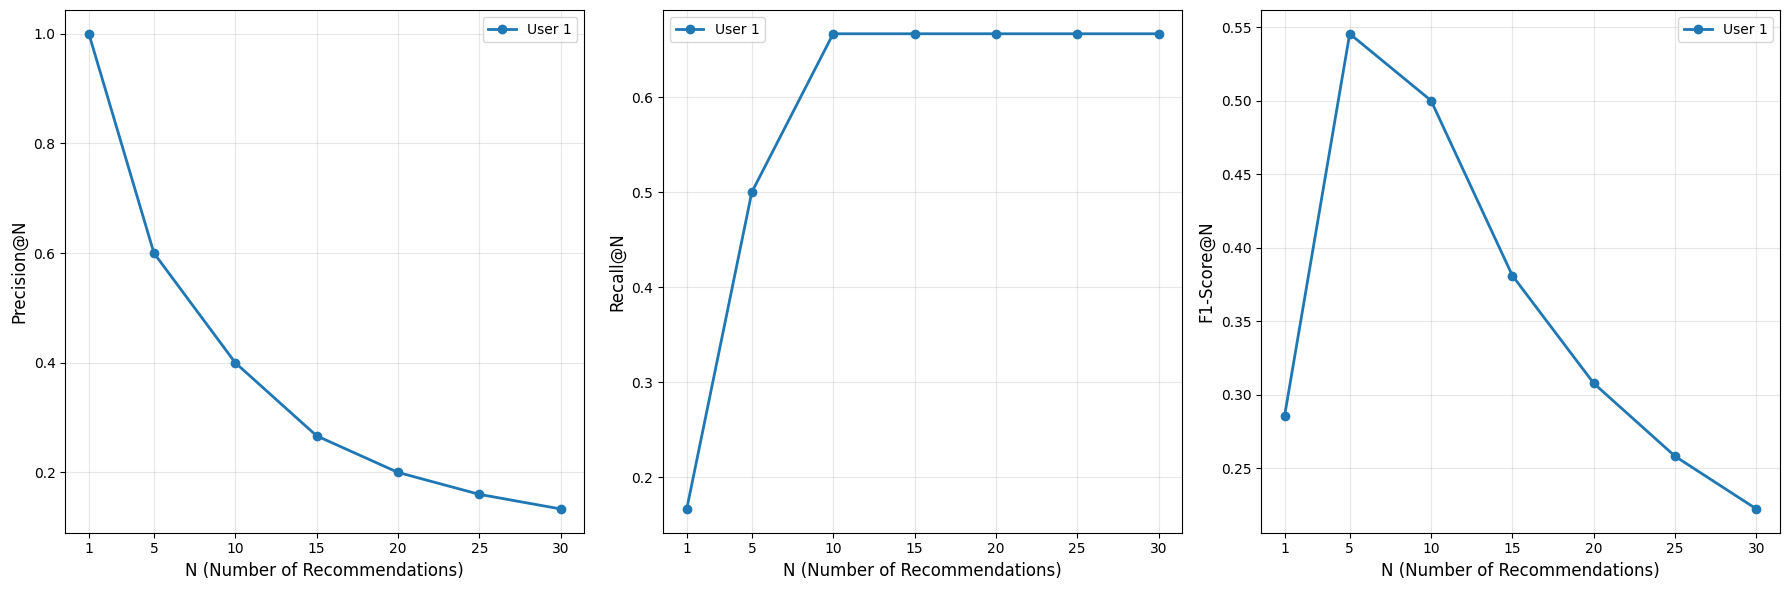

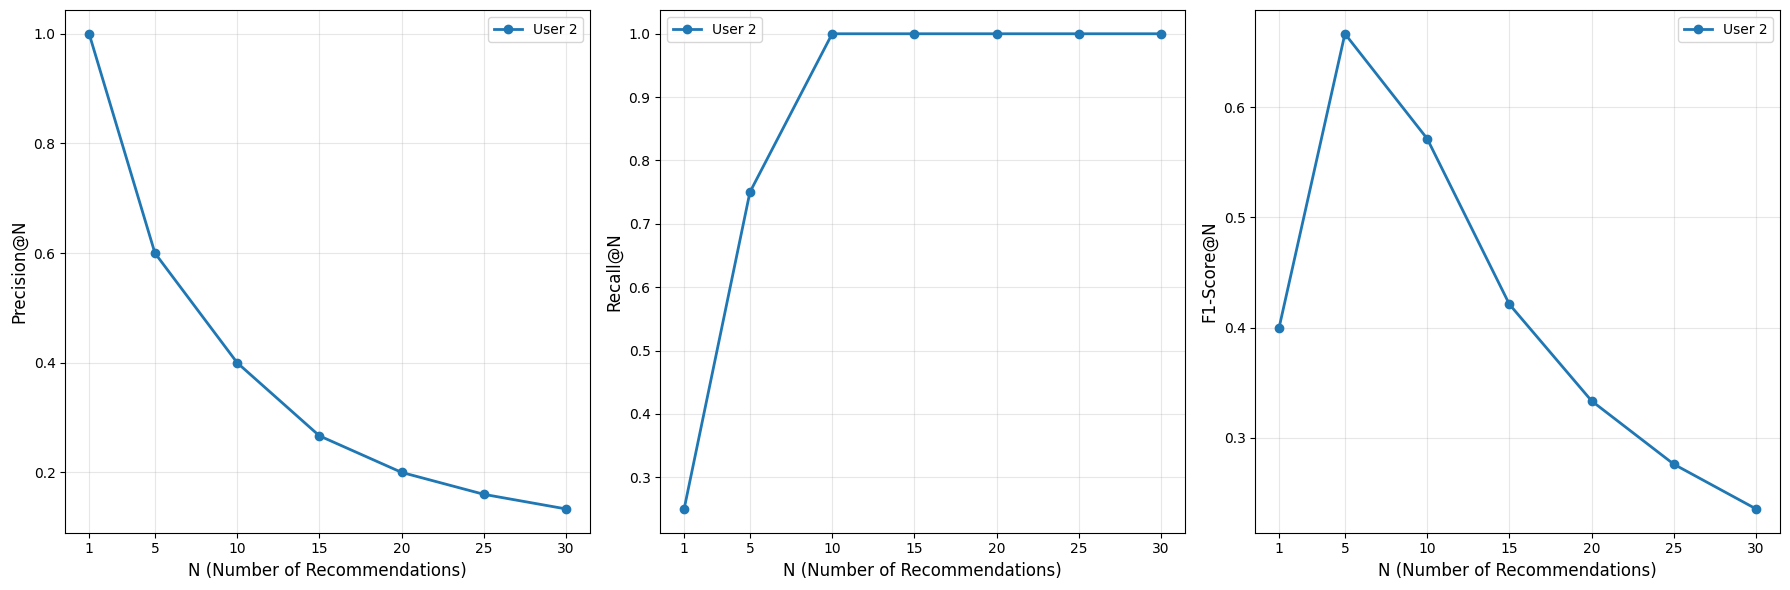

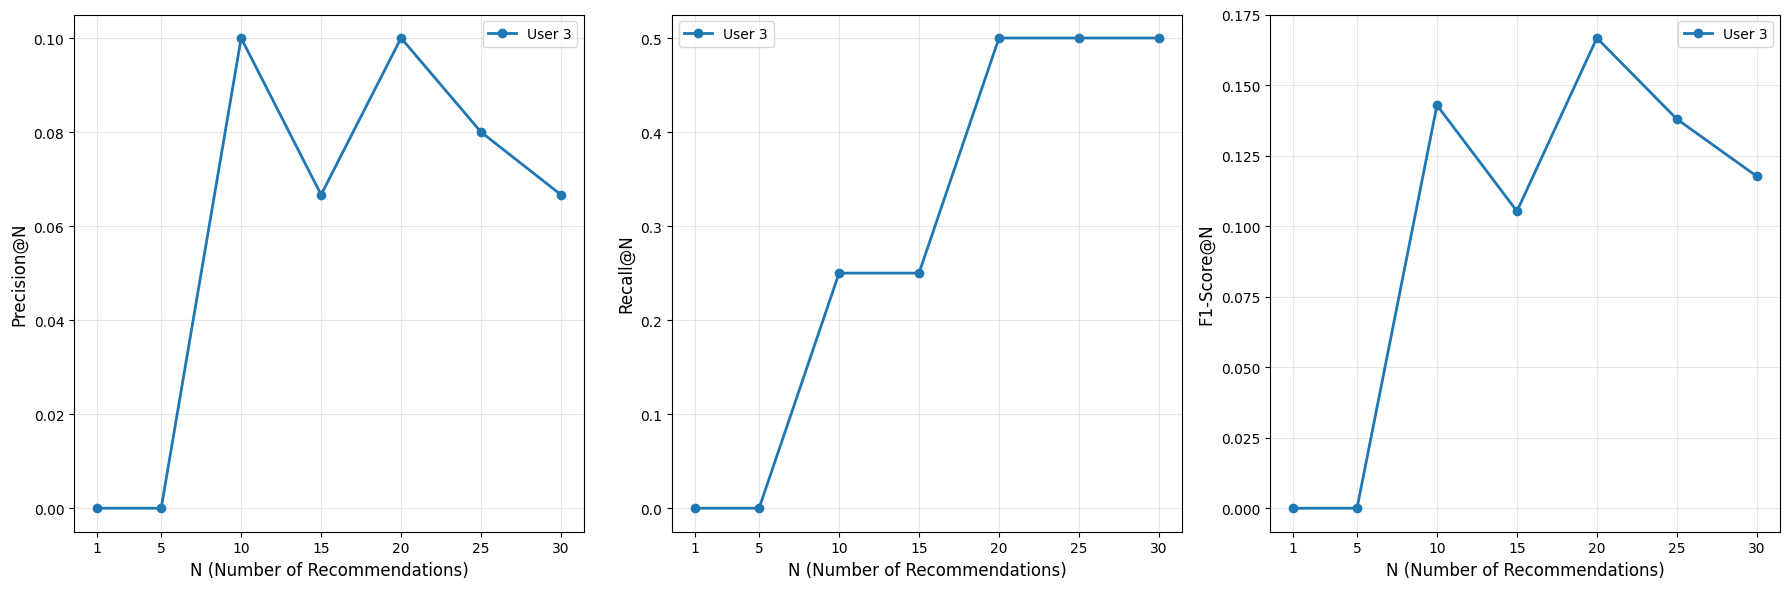

In [36]:
import matplotlib.pyplot as plt

# Create visualisation of N optimisation results
for user_name in users.keys():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    metrics = ["precision_at_n", "recall_at_n", "f1_score_at_n"]
    metric_titles = ["Precision@N", "Recall@N", "F1-Score@N"]

    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        ax = axs[i]

        values = [n_results[n][user_name][metric] for n in N_VALUES]
        ax.plot(N_VALUES, values, marker="o", linewidth=2, label=user_name)

        ax.set_xlabel("N (Number of Recommendations)", fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_xticks(N_VALUES)

    plt.tight_layout()
    plt.show()

In [37]:
# Analyse optimal N for each topic individually by averaging across users
avg_results = {}

# Calculate average F1 score for this topic across all users for each N
for n in N_VALUES:
    total_precision = total_recall = total_f1 = 0
    user_count = 0

    for user_name in users.keys():
        total_precision += n_results[n][user_name]["precision_at_n"]
        total_recall += n_results[n][user_name]["recall_at_n"]
        total_f1 += n_results[n][user_name]["f1_score_at_n"]
        user_count += 1

    avg_results[n] = {
        "avg_precision": total_precision / user_count,
        "avg_recall": total_recall / user_count,
        "avg_f1_score": total_f1 / user_count
    }

# Display average results table
avg_table = {
    "N": N_VALUES,
    "Avg Precision": [f"{avg_results[n]['avg_precision']:.4f}" for n in N_VALUES],
    "Avg Recall": [f"{avg_results[n]['avg_recall']:.4f}" for n in N_VALUES],
    "Avg F1 Score": [f"{avg_results[n]['avg_f1_score']:.4f}" for n in N_VALUES]
}

avg_df = pd.DataFrame(avg_table)
print(avg_df.to_string(index=False))

# Find best N across users based on average F1 score
best_topic_n = max(N_VALUES, key=lambda n: avg_results[n]["avg_f1_score"])
print(f"\nOptimal N = {best_topic_n}")
print(f"Average Precision at optimal N = {avg_results[best_topic_n]['avg_precision']:.4f}")
print(f"Average Recall at optimal N = {avg_results[best_topic_n]['avg_recall']:.4f}")
print(f"Average F1 at optimal N = {avg_results[best_topic_n]['avg_f1_score']:.4f}")

 N Avg Precision Avg Recall Avg F1 Score
 1        0.6667     0.1389       0.2286
 5        0.4000     0.4167       0.4040
10        0.3000     0.6389       0.4048
15        0.2000     0.6389       0.3024
20        0.1667     0.7222       0.2692
25        0.1333     0.7222       0.2240
30        0.1111     0.7222       0.1917

Optimal N = 10
Average Precision at optimal N = 0.3000
Average Recall at optimal N = 0.6389
Average F1 at optimal N = 0.4048


__2.5.2. Conclusion__

Based on the performance across different topics and N values, the optimal recommendation strategy is to **recommend a fixed N=10** for our recommendation system (_*Part 2 Question 2_), achieving highest average precision of 0.3, average recall of 0.6389, and average f1 score of 0.4048. The choice of N=10 also represents a balance of performance and usability, as it is a manageable number of recommendations that can be evaluated by user in a single session. This configuration will be used consistently in our recommendation system and forms the basis for the user study evaluation in Part 3.

#### 2.6. Choosing Optimal M (Top Words in User Profiles)

The number of top words (M) to represent each user's profile for each topic has an impact on recommendation quality. Using too few words may oversimplify user preferences, while using too many words may lead to noise. As a result, we need to find the optimal M that captures our users' preferences without overwhelming our system with irrelevant information.

__2.6.1. Experiment Setup__

To choose the optimal M, we'll utilise our function `build_user_profile` to limit each profile to the top M most important words (highest TF-IDF scores). We'll test different values of M (5, 10, 20, 30, 50, 100, None) (None = "All words") using our best performing configuration: Jaccard Similarity with a fixed N=10 recommendations chosen in section 2.5.

In [38]:
import pandas as pd

# Define optimal N
OPTIMAL_N = 10

# Define range of M values to test
M_VALUES = [5, 10, 20, 30, 50, 100, 250, 500, 1000, None]

# Store results for analysis
m_results = {}

# Test each M value across all users using Jaccard Similarity
for m in M_VALUES:
    m_results[m] = {}

    for user_name, (interests, _) in users.items():
        # Build profile with every M
        user_profile = build_user_profile(interests, M=m, output=False)

        # Get recommendations using the user profile
        _, result = get_recommendations(
            interests, user_profile, jaccard_similarity_fn,
            N=OPTIMAL_N, output=False
        )
        m_results[m][user_name] = result

# Display detailed results for each user
for user_name, (_, user_profile) in users.items():
    print("=" * 5, f"{user_name.upper()} M OPTIMISATION RESULTS", "=" * 5)

    # Store metrics across all M values
    results_table = {
        "M": M_VALUES,
        "Precision": [f"{m_results[m][user_name]['precision_at_n']:.4f}"
                        for m in M_VALUES],
        "Recall": [f"{m_results[m][user_name]['recall_at_n']:.4f}"
                    for m in M_VALUES],
        "F1 Score": [f"{m_results[m][user_name]['f1_score_at_n']:.4f}"
                    for m in M_VALUES],
        "Liked Found": [f"{m_results[m][user_name]['number_liked_recommended_songs']} / {OPTIMAL_N}"
                        for m in M_VALUES]
    }

    results_df = pd.DataFrame(results_table)
    print(results_df.to_string(index=False))
    print()

===== USER 1 M OPTIMISATION RESULTS =====
     M Precision Recall F1 Score Liked Found
   5.0    0.1000 0.1667   0.1250      1 / 10
  10.0    0.1000 0.1667   0.1250      1 / 10
  20.0    0.0000 0.0000   0.0000      0 / 10
  30.0    0.0000 0.0000   0.0000      0 / 10
  50.0    0.1000 0.1667   0.1250      1 / 10
 100.0    0.1000 0.1667   0.1250      1 / 10
 250.0    0.1000 0.1667   0.1250      1 / 10
 500.0    0.1000 0.1667   0.1250      1 / 10
1000.0    0.3000 0.5000   0.3750      3 / 10
   NaN    0.4000 0.6667   0.5000      4 / 10

===== USER 2 M OPTIMISATION RESULTS =====
     M Precision Recall F1 Score Liked Found
   5.0    0.0000 0.0000   0.0000      0 / 10
  10.0    0.0000 0.0000   0.0000      0 / 10
  20.0    0.0000 0.0000   0.0000      0 / 10
  30.0    0.0000 0.0000   0.0000      0 / 10
  50.0    0.1000 0.2500   0.1429      1 / 10
 100.0    0.1000 0.2500   0.1429      1 / 10
 250.0    0.3000 0.7500   0.4286      3 / 10
 500.0    0.1000 0.2500   0.1429      1 / 10
1000.0    0.400

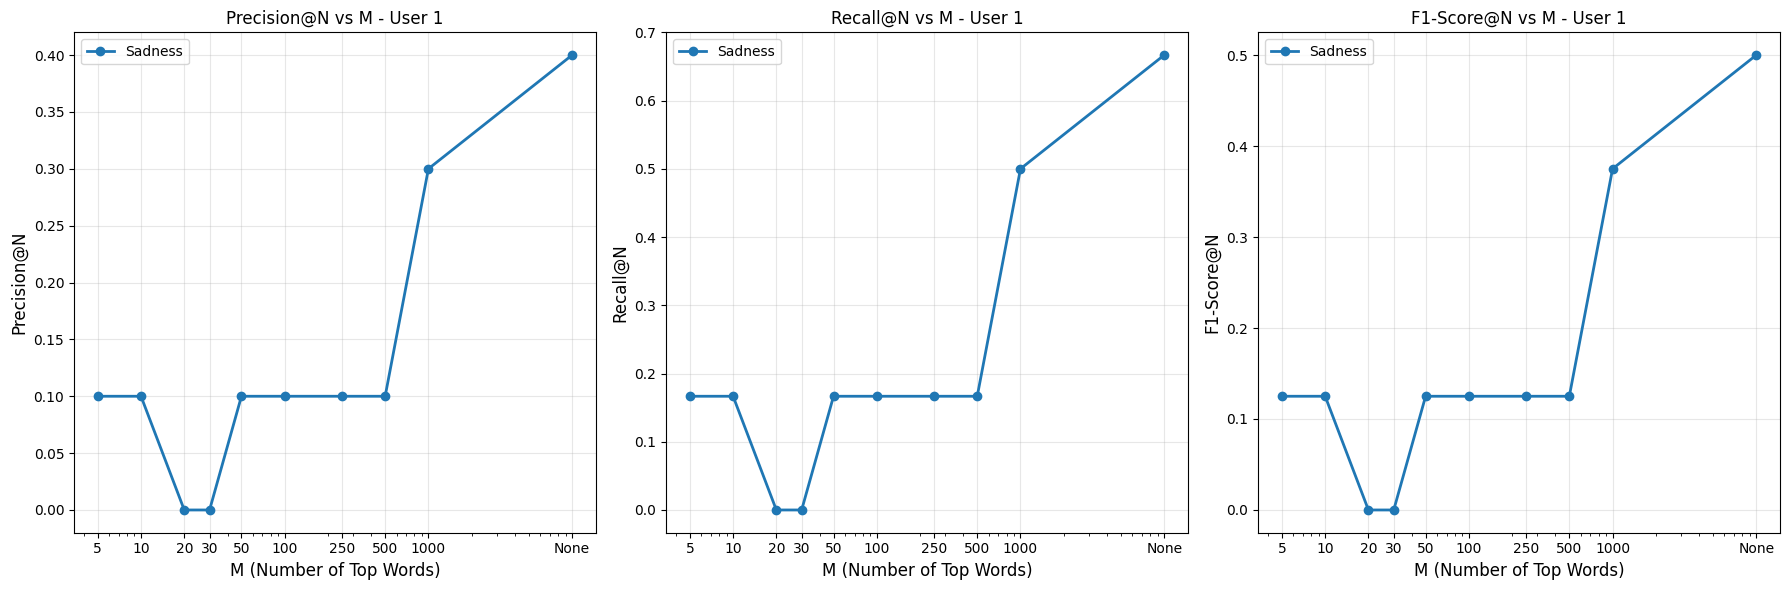

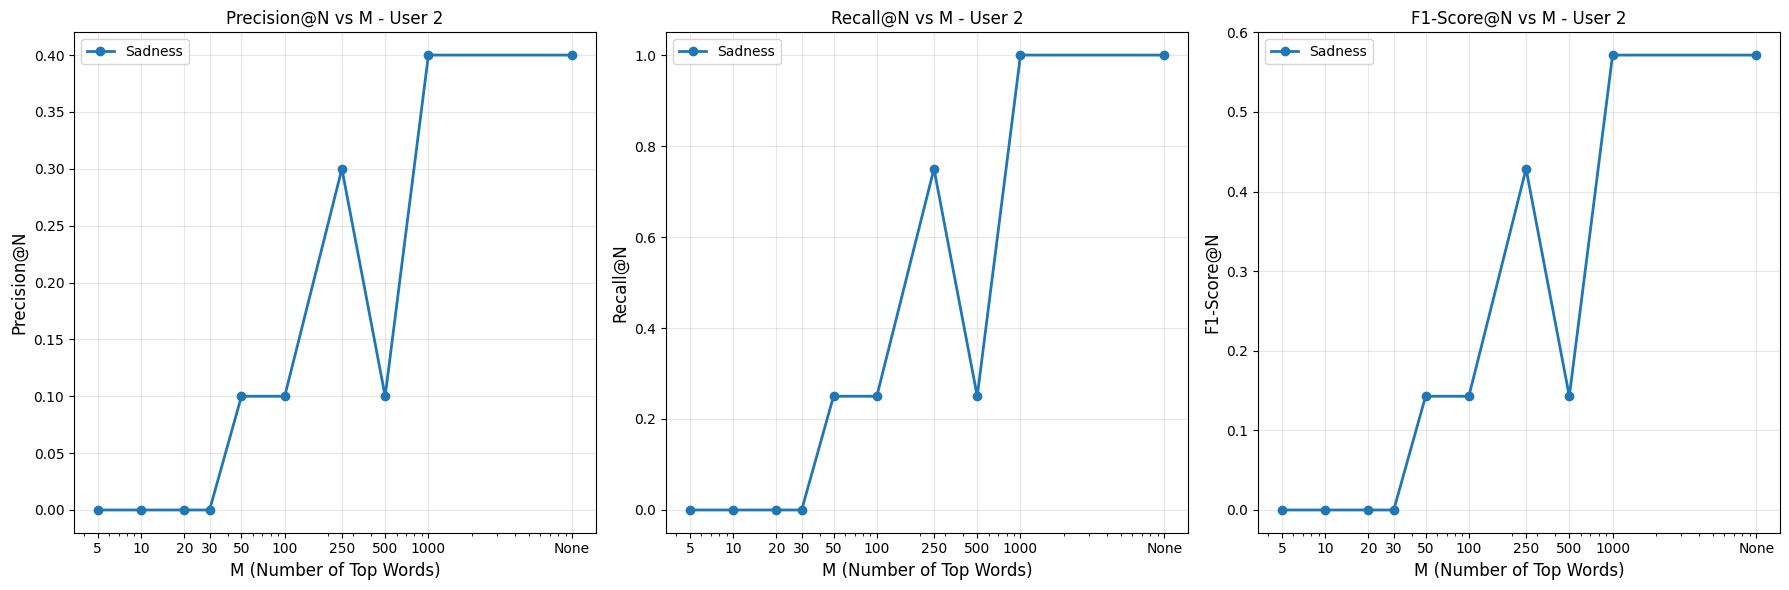

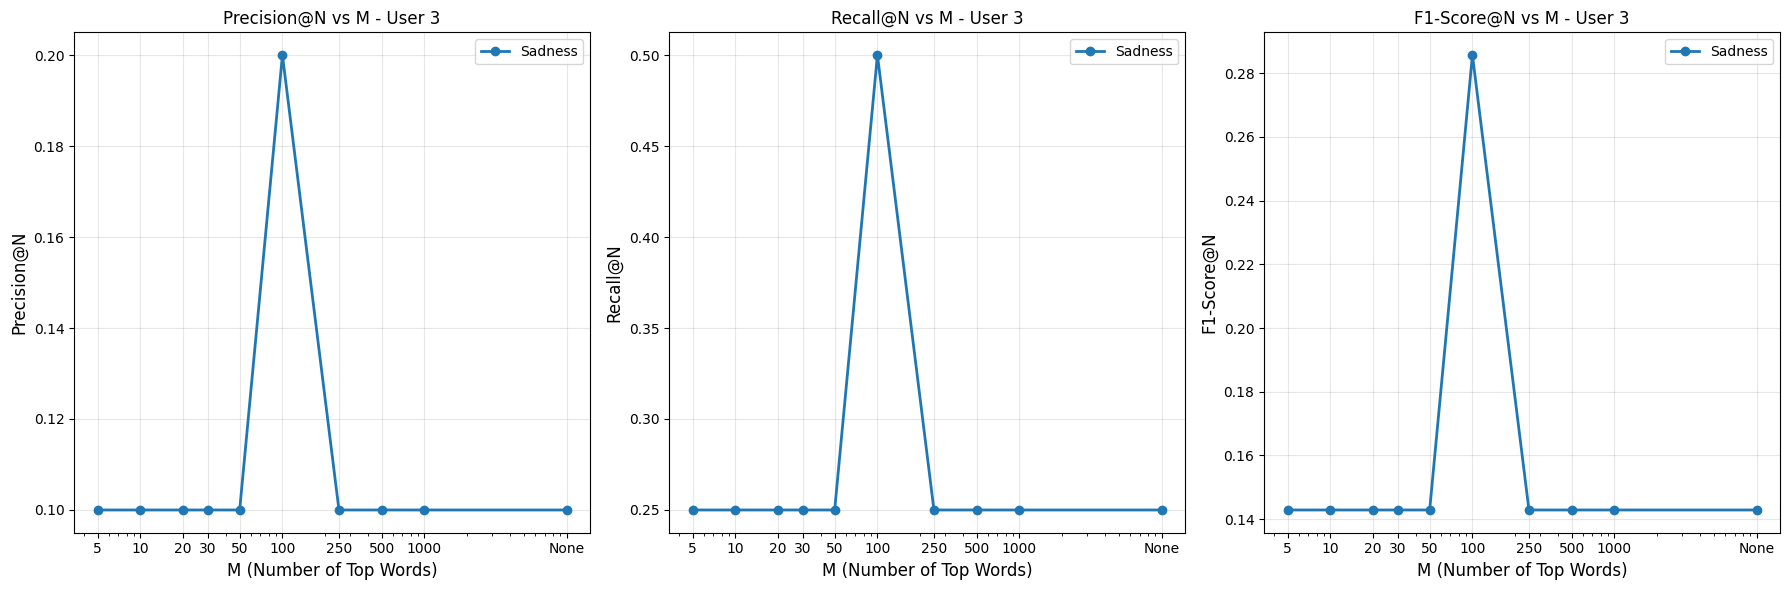

In [39]:
import matplotlib.pyplot as plt

# Create visualization of M optimisation results
for user_name, (user_interests, _) in users.items():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    metrics = ["precision_at_n", "recall_at_n", "f1_score_at_n"]
    metric_titles = ["Precision@N", "Recall@N", "F1-Score@N"]

    # Convert M_VALUES for plotting (treat None as a large number for visualization)
    m_plot_values = [m if m else 10000 for m in M_VALUES]
    m_plot_labels = [str(m) if m else "None" for m in M_VALUES]

    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        ax = axs[i]

        values = [m_results[m][user_name][metric] for m in M_VALUES]
        ax.plot(m_plot_values, values, marker="o", linewidth=2, label=topic.capitalize())

        ax.set_xlabel("M (Number of Top Words)", fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(f"{title} vs M - {user_name}")
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_xscale('log')  # Use log scale
        ax.set_xticks(m_plot_values)
        ax.set_xticklabels(m_plot_labels)

    plt.tight_layout()
    plt.show()

In [40]:
import pandas as pd

# Calculate average performance across all users and topics for each M
avg_results = {}
for m in M_VALUES:
    total_precision = total_recall = total_f1 = 0
    count = 0

    for user_name, (user_interests, _) in users.items():
        total_precision += m_results[m][user_name]["precision_at_n"]
        total_recall += m_results[m][user_name]["recall_at_n"]
        total_f1 += m_results[m][user_name]["f1_score_at_n"]
        count += 1

    avg_results[m] = {
        "avg_precision": total_precision / count,
        "avg_recall": total_recall / count,
        "avg_f1_score": total_f1 / count
    }

# Display average results table
avg_table = {
    "M": M_VALUES,
    "Avg Precision": [f"{avg_results[m]['avg_precision']:.4f}" for m in M_VALUES],
    "Avg Recall": [f"{avg_results[m]['avg_recall']:.4f}" for m in M_VALUES],
    "Avg F1 Score": [f"{avg_results[m]['avg_f1_score']:.4f}" for m in M_VALUES]
}

avg_df = pd.DataFrame(avg_table)
print(avg_df.to_string(index=False))

# Find optimal M
best_m = max(M_VALUES, key=lambda m: avg_results[m]["avg_f1_score"])
print(f"\nOptimal M based on average F1 score: {best_m}")
print(f"Average F1 score at optimal M: {avg_results[best_m]['avg_f1_score']:.4f}")

     M Avg Precision Avg Recall Avg F1 Score
   5.0        0.0667     0.1389       0.0893
  10.0        0.0667     0.1389       0.0893
  20.0        0.0333     0.0833       0.0476
  30.0        0.0333     0.0833       0.0476
  50.0        0.1000     0.2222       0.1369
 100.0        0.1333     0.3056       0.1845
 250.0        0.1667     0.3889       0.2321
 500.0        0.1000     0.2222       0.1369
1000.0        0.2667     0.5833       0.3631
   NaN        0.3000     0.6389       0.4048

Optimal M based on average F1 score: None
Average F1 score at optimal M: 0.4048


__2.6.2. Conclusion__

Based on the analysis of different M values, **M=None (All words) is the best choice** for our recommendation system, achieving the highest average F1 score of 0.4048, precision of 0.30 and recall of 0.6389. The reason why this is the case is because song lyrics oftenly express complex, nuanced emotions that require a lot of vocabulary to capture subtle differences between topics, and the moderate M values (5-1000) consistently underperformed, suggesting that restrictions introduce more noise than benefit.

#### 2.7. Conclusion

Based on the evaluation of different similarity algorithms, N values, and M values, our **final recommendation system configuration** uses (_*Part 2 Question 2_):

- **Similarity Algorithm**: Jaccard Similarity - chosen for its performance across precision, recall, and F1-score compared to Cosine Similarity, and Euclidean distance.
- **Number of Recommendations (N)**: Fixed N=10 - provides a reasonable user experience while maintaining acceptable performance across all topics.
- **User Profile Words (M)**: All words (M=None) - using the complete TF-IDF vocabulary rather than restricting to top words, as this achieved the highest average F1 score of 0.4048.

This setup gives the best balance of good recommendations without overwhelming users. Using all the vocabulary captures the complexity of song lyrics, while keeping recommendations to 10 items keeps things manageable.

### Part 3 - User Evaluation

#### 3.1. User Study Design

**Participant**

[Brief description of your test user - age range, musical background, etc.]

**Study Protocol**

We simulate a 4-week deployment where a real user interacts with our recommendation system over time. The user is shown random songs from weeks 1-3 to establish preferences (training data), then receives personalised recommendations for week 4 (testing phase).

Then, songs are shown to the user showing artist name, track name, genre, and the first few lines of lyrics. The user evaluates each song with a simple "like/dislike" response while providing feedback about their reasoning.

#### 3.2. Data Collection

In [41]:
pd.set_option("display.max_colwidth", None)  # Show full lyrics

__3.2.1. Week 1 Random Songs__

In [42]:
import random

# Set random seed for reproducibility
random.seed(42)

N = 10  # Number of songs to show per week (from Part 2)

# Sample N random songs from Week 1 (rows 1 - 250)
week_1_indices = random.sample(range(0, 250), N)
week_1_songs = df.iloc[week_1_indices]

print("Instruction:")
print("For each song, indicate if you would 'like' or 'dislike' it.")
print("Please talk aloud about your reasoning.")

week_1_songs[["artist_name", "track_name", "genre", "lyrics"]]

Instruction:
For each song, indicate if you would 'like' or 'dislike' it.
Please talk aloud about your reasoning.


,artist_name,track_name,genre,lyrics
163,skillet,anchor,rock,driftin beneath horizon body weak tryin shore fallin short need wave wave sinkin unto promise clingin strong belong holdin anchor steady steady anchor keepin feet grind angry oceans break wave anchor steady steady come steady steady tire fightin fear hidin give breath tell rest leave hear callin pullin shame face rain anchor steady steady anchor keepin feet grind angry oceans break wave anchor steady steady come steady steady wanna know drown anchor steady steady wanna anchor keepin feet grind know drown angry oceans break wave anchor steady steady come steady steady
28,imagine dragons,walking the wire,rock,feel away oohoh oohoh know line walk oohoh oohoh turn come come rag oohoh oohoh afraid fall look oohoh oohoh take step take leap come come feel wind hair feel rush walk wire walk wire couldn higher walk wire wire wire nights walk away oohoh oohoh tear tear fade oohoh oohoh lyric commercial
6,rebelution,trap door,reggae,long long road occur look shortcut wanna cause scene wanna close okay outspoken look trap door sneak grind floor careful wish need answer head time solve problems scream perfect expect human look trap door sneak grind floor careful wish
189,andy grammer,wish you pain,rock,doubt come like monsters terrorize dream feel lonely hopelessness cause believe question fear like poison get blood push breathe life line everybody watch fall cause know heart grow time break know sound strange wish pain wish pain hard lyric commercial
70,scotty mccreery,this is it,country,mountains thousand feet high trail tree meet view step baby okay open eye talk bout look forever hand moment forget world time perfect kiss girl know wait talk friends wonder wonder wonder wait hold ring right word right time place knee talk bout look forever hand moment forget world time perfect kiss walk aisle help smile talk bout look forever hand moment forget forget world surround family friends time perfect kiss yeah
62,jd mcpherson,desperate love,blues,desperate knees flesh bone blood beg life speak survive desperate time wait patiently luck change stand dreadfully night sorrow shame toss wave look desperate knees flesh bone blood beg life speak survive desperate time runnin wild like plain stand outside pray sweet relief pourin rain sorrow shame toss wave look desperate knees flesh bone blood beg life help survive desperate survive desperate
57,gregg allman,going going gone,blues,reach place bend say go go go close book page text care happen go go go hang thread play straight loose get late go go go go grandma say follow heart fine line gold shine true walk road live edge reach ledge go go go go go go go go go go go go go go go
35,george strait,take me away,country,wild horse couldn drag away today tonight time girl gonna happen wonderin askin farthest thing mind place girl happenin pull fast ones gonna away away gonna away girl hand wanna suit fine talk gonna walk lock eye right like like star fly moon shin perfect time gonna away away gonna away baby gonna break chain strongest wind hurricane gonna away away gonna away breath neck right tear head spinnin round faster cause know gonna away away gonna away away gonna away
188,the movement,cool me down,reggae,fight thoughts suicide alive comprise give realize life homie time doubt cause dream mind work time get closer happiness inside aren movement surely leave back falcon punch game leave ash shed tear cause legacy mixtapes couple single couple fan cool life get pretty hard feel like give start relight passion heart know life thankful oldest dream come conquer supreme wait money purchase things reality dangerous wish fall asleep life quick women aren speed fall dream mean bless life teach lessons pretty thankful live future hand drop guess learn spill solely focus make kill track multisyllable verse provide music crack sixteens pointless rhyme favorite album okay like music ahead dance prowl freakin problem nerdy love cartoon ahead doubt

**Participant's Week 1 Analysis**

| Song ID | Like/Dislike | Description |
|---------|--------------|-------------|
| 163 | Dislike | Doesn't align with participant's preferences |
| 28 | Like | Loved the "oooh" ad libs - catchy |
| 6 | Dislike | Doesn't align with participant's preferences |
| 189 | Like | Could relate to the loneliness and sad emotions |
| 70 | Like | Countryside love theme felt sweet and genuine |
| 62 | Dislike | Too depressing and hopeless; participant found it overwhelming |
| 57 | Like | Catchy because of the repetitive "go" word |
| 35 | Like | Repetitive "away" ad libs; lighthearted, wholesome country love theme |
| 188 | Dislike | Too gloomy and depressive |
| 26 | Dislike | Dislikes materialistic/flex content |

The participant showed strong preferences for songs with emotional depth and relatability. They liked songs that touched on loneliness and sadness (song 189), countryside love (song 70), and songs with catchy repetitive words like "go" (song 57) and "away" (song 35). On the other side, they weren't into songs that felt too dark, hopeless, or materialistic "flex" related songs. Overall, they seem to prefer emotional songs that are thoughtful but not too heavy.

__3.2.2. Week 2 Random Songs__

In [43]:
import random

# Set random seed for reproducibility
random.seed(42)

N = 10  # Number of songs to show per week (from Part 2)

# Sample N random songs from Week 2 (rows 251 - 500)
week_2_indices = random.sample(range(250, 500), N)
week_2_songs = df.iloc[week_2_indices]

print("Instruction:")
print("For each song, indicate if you would 'like' or 'dislike' it.")
print("Please talk aloud about your reasoning.")

week_2_songs[["artist_name", "track_name", "genre", "lyrics"]]

Instruction:
For each song, indicate if you would 'like' or 'dislike' it.
Please talk aloud about your reasoning.


,artist_name,track_name,genre,lyrics
413,camila cabello,crying in the club,pop,think know tell fear forever true true true arm tonight music lift like high open heart music lift like free feel sunrise music warm body like heat thousand fire heat thousand fire cry club beat tear fall baby cry club little tear turn ecstasy cry club cry club cry club think know tell fear meet pure true true true arm tonight music lift like high open heart music lift like free feel sunrise music warm body like heat thousand fire heat thousand fire cry club beat tear fall baby cry club little tear turn ecstasy cry club cry club cry club think know tell fear forever true true true say cry cry club cry say cry cry club cry woah cry club beat tear fall baby cry club little tear turn ecstasy cry club cry club cry club cry club cry club
278,black pistol fire,wake the riot,blues,bite tongue shout lungs bore tear like track sell score force hand wicked command better white knuckle crimson crown catch trippin baby riot riot riot riot know baby bind break fight weak hand size little lie blame force hand wicked command better white knuckle crimson crown catch trippin baby riot riot riot know riot take share bore walk hand hand devil time throw roll tear waitin long waitin long baby riot
256,the kills,black tar,blues,invention handsome fairytales fair game world look sharpen blade london blood thirsty paris vein open vein pulse mean bruise wing sparrow gonna catch hair night arrow prick quick pick fight world trip bid blood catatonia york black run run bruise wing sparrow cook light tuck prim prim divine cool thing crazy look white screen field daisies pull stay stand stay stand
439,sticky fingers,angel,reggae,live life golden disguise fall swim deepest ocean wise stone sentimental cause home head strong move wise stone blind break hogtied soft speak stiffly stir awake throw bone throw bone cook alive sleep drown mess pull wing live life golden despite omen shiver coldest wise stone wise stone wise stone cook alive sleep drown mess pull wing cook alive sleep drown mess pull wing say sorry
320,thank you scientist,geronimo,jazz,peace worst time dedicate moment cross world try fee hate inside prey fear satisfy tame universe deal commotion know wave ocean take need understand defenseless geronimo bone need ready forward stride leave finally start heal longer need numb pain forget think hopeless remember room grow outside wall surround want impossible logical reverse gravity make heights see gratify need comprehend force feel see world beauty eye gratify clearly time life season spend solitude spend solitude poison pump heart vein heart vein lose foot walk tightrope walk tightrope seek balance come believe know time reverse gravity make heights see gratify need comprehend force feel see world beauty eye gratify clearly time clearly time clearly time life
312,dorothy,raise hell,blues,gotta raise little hell young blood like river young blood chain young blood heaven need sinner raise hell saint young blood come start riot care young blood heaven hate sinner gonna raise hell raise hell raise hell somebody gotta gotta raise little hell baby drop bone baby sell soul heaven fare thee somebody gotta gotta raise little hell hell yeah somebody gotta gotta raise little hell hell yeah somebody gotta gotta raise little hell young blood stand deliver need queen young gotta pull trigger world run scar raise hell baby drop bone baby sell soul heaven fare thee somebody gotta gotta raise little hell hell yeah somebody gotta gotta raise little hell hell yeah somebody gotta gotta raise little hell
307,damian marley,slave mill,reggae,remember slavery time work dollar slave grind slow grind walk home youth get kill police free shoot slave grind slow grind know drill weekend short live thrill slave grind slow grind runneth till spill slave grind slow grind think cause give job pay boast brag think small riches flesh touch respect name respect love respect life worship matter cost prac

**Participant's Week 2 Analysis**

| Song ID | Like/Dislike | Description |
|---------|--------------|-------------|
| 413 | Dislike | Too sad and depressed; excessive use of "cry" |
| 278 | Dislike | Didn't like the rebellious/aggressive theme |
| 256 | Like | Liked the wholesome, melancholy feel |
| 439 | Like | Sentimental in a way that hit emotionally |
| 320 | Like | Liked the positive message about self-growth |
| 312 | Dislike | Disliked rebellious/aggressive theme |
| 307 | Dislike | "Grind set" mentality felt a bit "toxic" |
| 285 | Like | Sad but in a light, digestible way |
| 438 | Dislike | Too repetitive; too exhausting/draining |
| 276 | Dislike | "Funky" described as weird; Dislikes "unserious" songs |

The participant's preferences became a bit clearer this time. They weren't into aggressive or rebellious songs, but liked with ones that felt wholesome and melancholic (song 256), sentimental (song 439), or focused on personal growth (song 320). They disliked "grind set" mentality song, call it "toxic", and didn't enjoy songs that felt too repetitive or "unserious". Here, they also liked songs with the "lighthearted sadness" theme, and thus confirming their preference for balanced emotional content.

__3.2.3. Week 3 Random Songs__

In [44]:
import random

# Set random seed for reproducibility
random.seed(42)

N = 10  # Number of songs to show per week (from Part 2)

# Sample N random songs from Week 2 (rows 501 - 750)
week_3_indices = random.sample(range(500, 750), N)
week_3_songs = df.iloc[week_3_indices]

print("Instruction:")
print("For each song, indicate if you would 'like' or 'dislike' it.")
print("Please talk aloud about your reasoning.")

week_3_songs[["artist_name", "track_name", "genre", "lyrics"]]

Instruction:
For each song, indicate if you would 'like' or 'dislike' it.
Please talk aloud about your reasoning.


,artist_name,track_name,genre,lyrics
665,alfa mist,breathe,jazz,destiny say prove mountains hear call star come night shine till morning daylight numb warm heart mouth breath eeeh mouth breath come sweet poetry dream freeze night forget call star come night shine till morning daylight numb warm heart mouth breath eeeh mouth breath
528,carrie underwood,the bullet,country,line limousines leave prayers pray hymn sing black mascara tear flowin blame hate blame gun mama suppose bury sons leave hole heart bullet keep goin branch family tree birthday live good life steal raise daughter wed wishin hand holdin till heart leave break break bullet keep goin grass grow stone friends stop checkin phone camera crew move wind open bullet keep goin branch family tree birthday live good life steal raise daughter wed wishin hand holdin till heart leave break break bullet keep goin yeah whoa line limousines leave prayers pray hymn sing mama suppose bury sons bullet keep goin raise daughter wed wishin hand holdin till heart leave break break bullet keep goin bullet keep goin
506,runaway june,buy my own drinks,pop,yeah try unfall apart think neon light real good start call couple friends stay guess go heart break mean gotta stay home yeah drink night light drop change jukebox dance stop thinkin bout drinkin bout need yeah drink tonight tonight tonight yeah drink tonight tonight tonight dive type walk see drink hand yeah say sweet glass gonna pass time yeah fine drink night light drop change jukebox dance stop thinkin bout drinkin bout need yeah drink tonight tonight tonight yeah drink tonight tonight tonight walk self door self medicate headache yeah boyfriend drink night light drop change jukebox dance time stop stop thinkin bout drinkin bout need yeah drink tonight tonight tonight yeah drink tonight tonight tonight drop change jukebox tonight tonight tonight thinkin bout drinkin bout dance tonight tonight tonight
691,nai palm,homebody,jazz,hold colour reach pain home worry bury memories hold hold time come meet answer home body homebody
570,dorothy,28 days in the valley,blues,young free days valley young free days valley young free days valley
562,magnus lindgren,theme for laura,jazz,walk wonder go wrong strong walk think things awhile hearts young awalkin rain tear fallin feel pain wishin misery wonder away wonder awhere stayay little runaway runaway awalkin rain tear fallin feel pain wishin misery wonder away wonder awhere stayay little runaway runaway runaway runaway
557,bullet for my valentine,over it,rock,time couldn recognise problem lie vicious circle tell throw away cause make sense wouldn listen know hurt try help ease pain know word mean hurt blame anymore watch decline expect save want save lyric commercial
535,cyrille aimee,loving you,jazz,love choice love choice reason rejoice give purpose give voice world live live love things love control love goal leave life live love things love control love goal leave life live live
690,yungblud,medication,rock,prescribe medication doctor lonely mistake paint family smudge grenade tape face get drink quarter geeza key mouth gonna bite normal pope right clown lose white light white heat shots arm street lose white light white heat blank shout wanna wanna medication wanna wanna motivation wanna wanna medication wanna lyric commercial
526,thank you scientist,prologue: a faint applause...,jazz,know begin conversation word fall deaf ears sink float hesitate come start move sing song know word right throw away move sing song little cliche right know move sing song move sing song


**Participant's Week 3 Analysis**

| Song ID | Like/Dislike | Description |
|---------|--------------|-------------|
| 665 | Like | 	Had a peaceful, calming vibe |
| 528 | Dislike | Too dark for their preferences |
| 506 | Like | Mindless party lyrics that don't feel overwhelming |
| 691 | Dislike | Boring romance content |
| 570 | Like | Light-hearted and feels freeing |
| 562 | Dislike | Lyrics don't fit the genre appropriately |
| 557 | Like | About attempting to ease pain but not too deep |
| 535 | Dislike | Boring love song with slow, repetitive lyrics |
| 690 | Like | Liked the storytelling vibe throughout |
| 526 | Dislike | Life experience themes not interesting to participant |

The participant seemed to enjoy songs with a peaceful, calming vibe (song 665) and didn’t mind light, “mindless” party lyrics as long as they weren’t too much (song 506). They liked content that felt freeing and easygoing (song 570), and enjoyed songs that touched on easing pain without getting overly deep or heavy (song 557). On the other side, they again weren’t into dark themes, dull romance, lyrics that felt out of place or too serious, emphasising their preference for songs that felt relatable and easy to connect with.

__3.2.4. Participant's Profile__

The participant consistently preferred:
- Melancholic but not overwhelming emotional content
- Songs with storytelling and depth
- Wholesome themes over aggressive or materialistic ones
- Light-hearted theme without being "too deep"
- Genre-appropriate lyrics

Based on the songs the participant liked over the first three weeks, we came up with few keywords for each topics. These keywords come directly from the participant's own descriptions and from the lyrics of songs they liked:

In [45]:
participant_interests = {
    "dark": ["quiet", "alone", "drift", "fading", "away"],
    "emotion": ["shine", "true", "walk", "warmth", "feeling", "memory", "soft"],
    "personal": ["forever", "perfect", "change", "hope", "better", "journey", "go"],
    "lifestyle": ["breeze", "night", "home"],
    "sadness": ["oohoh", "feel", "lonely", "moon", "miss", "quiet", "blue", "gone"],
}

This interest profile reflects the participant’s taste for gentle, relatable emotions like quiet sadness (“quiet”, “alone”) and warm, positive feelings (“shine”, “warmth”, “feeling”). They’re also drawn to themes of personal growth (“change”, “hope”, “better”) and everyday comforts (“breeze”, “night”, “home”). They seem to prefer softer, more manageable kinds of sadness (“feel”, “lonely”, “blue”) over anything too heavy or overwhelming. And the inclusion of words like “oohoh” and “go” shows they enjoy catchy, repetitive parts like the ones in the songs they liked.

In [46]:
# Build user profile for participant
print("=" * 20, "PARTICIPANT PROFILE", "=" * 20)
participant_profile = build_user_profile(participant_interests)

==================== PARTICIPANT PROFILE ====================
Topic: dark     | M: None | Active features: 1283 | Liked songs: 41 / 265
Top 20 words:
hollow, automaton, away, struggl, stand, wan, na, aliv, raindrop, head
feat, dodgin, come, know, tell, like, hand, mind, devil, time

Topic: emotion  | M: None | Active features: 282 | Liked songs: 9 / 37
Top 20 words:
hold, lip, go, feel, prais, know, soft, real, tight, night
strong, free, tri, money, keep, lose, away, mind, fade, babi

Topic: personal | M: None | Active features: 1591 | Liked songs: 70 / 180
Top 20 words:
thank, life, go, chang, million, lord, yeah, good, world, better
na, live, day, believ, oohoohoohooh, reason, know, land, mind, come

Topic: lifestyle | M: None | Active features: 818 | Liked songs: 38 / 86
Top 20 words:
home, night, come, closer, long, tire, spoil, song, na, wait
wan, play, ring, telephon, yeah, time, lalala, right, hear, depress

Topic: sadness  | M: None | Active features: 1327 | Liked songs: 95 / 1

#### 3.3. Recommendations Evaluation

__3.3.1. Generate Recommendations to Participant__

In [47]:
# Generate N recommendations for Week 4
recommendations, participant_result = get_recommendations(participant_interests, participant_profile,
                                         jaccard_similarity_fn, N=N, output=False)
recommendations[["artist_name", "track_name", "genre", "lyrics"]]

,artist_name,track_name,genre,lyrics
944,timeflies,once in a while,pop,think know better wishful think think pressure wishful drink forever feel afraid know brooklyn york cali khaled best strip stay american express live total request question like press road music truth worry bout catch need help feel like wanna dance feel good yeah feel good feel good good good good yeah feel good live life like blood type positive days feel opposite music like heroin hear hit time watch somebody copy bind feel fake like somebody need slow brown thoughts drown think know better wishful think think pressure wishful drink forever feel afraid know catch need help feel like wanna dance feel good feel good feel good good good good yeah feel good look go slow think give road slow turn graduate work come raise finish year right move tell tonight cause worry catch need help feel like wanna dance feel good yeah feel good feel good good good good yeah feel good wanna dance feel good
969,justin moore,got it good,country,wake morning warn little bounce blue eye start pillow talk twist sheet finger walk hell start yeah good sure good see smile kiss eye hips whoah tell like good good sure good good morning good late night good thing go good right turn kitchen light cork drink wine right outta bottle babe spin white noise record play little gaye minute bedroom bind yeah good sure good see smile kiss eye hips whoah tell like good good sure good good morning good late night good thing go good right good morning good late night good thing go good right yeah good sure good see smile kiss eye hips whoah tell like good good sure good good morning good late night good thing go good right
770,dirty heads,horsefly,reggae,say life live know things passionate sound real adamant come sentiment try losses horse race track track offense say yeah yeah dream speak cross list feel like feel like thousand reason feel good right good right feel like feel like thousand reason feel good right good right know cause wanna condolences follow path long path hard apologies need repeat know cause heart feel revel revel revel second devil devil devil inside head go away people style tell real fake feel like feel like thousand reason feel good right good right feel like feel like thousand reason feel good right good right feel like feel like thousand reason feel good right good right feel like feel like thousand reason feel good right good right feel like feel like thousand reason feel good right good right feel like feel like thousand reason feel good right good right
899,parker millsap,hands up,blues,easy hard wanna lump jacket yeah pistol open register grab fistful dollar bill hand baby home brother gotta fee know think kind trash stickin quiktrip desert serve tour crawlin dirt sweepin floor hard pretend hear body zip best friend hand hand hand hand anybody go church preacher say save soul show patrol bomb go point speak word english swear hear scream hand hand hand hand outta luck know feel feel stick like turn door slam shut hate pour salt hand
792,deca,donner bell,jazz,donner ready table live watchin star fall like confetti slip worm hole spiral descend pleasures fleshcovered meat light fare heavy peeve splittin hairs like cure lethargy selfhelp book alchemist secret recipes frequency adjust stark contrast tripe fee public speakin sayin things uptick cherrypicked data graph sevenheaded firebreathin dragon flyin head speakin sirens blarin cry tire screechin divide conquer prosecute high treason unpackin ration young snatchin crumb pump action semiautomatic tongue lash food think form fragment fraction fashion tree life compassion freeze light deepest night throw custom pair shade sight wolves masquerade lamb decent bite pig crack skull like whackamole read right holdin cell earth outer crust explore inner worlds outer husk hide principalities power corrupt pick flesh eagle bone grind dust trust discussin chord music strike acoustic string human gut night muse pluck remove cuff lo

**Participant's Week 4 Analysis**

| Song ID | Like/Dislike | Description |
|---------|--------------|-------------|
| 944 | Like | Solid, enjoyable pop song |
| 881 | Like | Sentimental/melancholic with storytelling elements |
| 969 | Dislike | Felt kind of flat; Lack dimensions |
| 984 | Dislike | Dark themes that participant dislikes |
| 770 | Dislike | Too repetitive for participant's preferences |
| 763 | Dislike | Found it problematic |
| 899 | Dislike | Also contains problematic content |
| 760 | Like | Liked the deeper explorations of guilt |
| 917 | Like | Enjoys the "oooh" elements despite some problematic words |

By the final week, the participant enjoyed songs with a story or depth (songs 881, 760, and 917). They also enjoyed straightforward pop songs (song 944) and tracks that touched on themes like feeling stuck, guilt, or taking responsibility, as long as the lyrics made sense. They still disliked dark or heavy themes that felt out of place, and stayed away from problematic content, though they were willing to overlook small issues if the overall lyrics resonated with them.

__3.3.2. Evaluation__

To evaluate the effectiveness of our recommendation system to the participant, we calculate the same metrics used in Part 2 and compared them to the participant's real choices during the 4-week simulation.

In [48]:
# Results from participant responses
total_recommendations = 10
liked_songs = 4
disliked_songs = 6

liked_test_songs = participant_result["number_liked_test_songs"]

# Calculate
precision_at_n = liked_songs / total_recommendations
recall_at_n = liked_songs / liked_test_songs if liked_test_songs else 0
f1_score_at_n = 2 * (precision_at_n * recall_at_n) / (precision_at_n + recall_at_n)

print(f"Precision@{total_recommendations}: {precision_at_n:.4f}")
print(f"Recall@{total_recommendations}: {recall_at_n:.4f}")
print(f"F1-Score@{total_recommendations}: {f1_score_at_n:.4f}")
print(f"Liked Songs: {liked_songs} / {total_recommendations}")

Precision@10: 0.4000
Recall@10: 0.0870
F1-Score@10: 0.1429
Liked Songs: 4 / 10


**User Study Results:**

- **Precision@10**: 0.400 - 40% of the recommended songs were liked by the participant
- **Recall@10**: 0.087 - Only 8.7% of songs the participant would potentially like were found
- **F1-Score@10**: 0.1429 - Balanced measure of precision and recall showing modest performance
- **Liked Songs**: 4 / 10 - Participant enjoyed 4 out of 10 recommendations

**Comparison with Part 2 Results**

| Metric | Part 2 (Theoretical) | Part 3 (Real User) | Difference |
|--------|----------------------|------------------- |------------|
| Precision@10 | 0.3000 | 0.4000 | +0.1 |
| Recall@10 | 0.6389 | 0.0870 | -0.5519 |
| F1 Score@10 | 0.4048 | 0.1429 | -0.2619 |

The actual user study showed mixed results compared to our earlier (theoretical) evaluation in Part 2. Precision improved a bit, but recall was significantly lower quite a lot, indicating a challenge in real-world deployment.

#### 3.4. Conclusion

We have successfully built and evaluated a music content-based recommendation system that uses topic classification to provide personalised song recommendations for different user profiles. The system progressed through three parts, each adding a key piece to the final implementation.

In Part 1, we created a topic classification model using Support Vector Machine (SVM). Through different experimentation with the preprocessing pipeline or feature selections, we achieved 88.58% classification accuracy using `TfidfVectorizer` with 550 features. The SVM classifier significantly outperformed both Bernoulli Naive Bayes (50.74% accuracy) and Multinomial Naive Bayes (77.97% accuracy), successfully classifying five different music topics: "dark", "emotion", "lifestyle", "personal", and "sadness".

Part 2 focused on building the recommendation system itself. We generated topic-specific TF-IDF matrices and developed user profile based on predicted topic classifications. After comparing multiple similarity algorithms, Jaccard Similarity is chosen as the best performer, and we determined optimal parameters of N=10 recommendations with M=None (utilising all vocabulary words) for user profiles.

In the final phase, we tested the recommendation system with a real user over simulated four weeks. The results showed mixed results, achieving 40% precision but facing challenges in recommendation coverage with only 8.7% recall, which means it missed a lot of songs the user would’ve liked. This highlighted the gap between controlled tests and messy real-world preferences, as our participant have preferences that proved challenging to capture accurately through our recommendation system.

Overall, the system works well for avoiding bad recommendations and staying within user preferences, which is important. However, it's a bit too conservative and limits its ability to introduce users to new music they might like. That said, our content-based music recommendation system provides a solid foundation for content-based music recommendations. It shows potential, especially in precision, and with targeted improvements to address the limitations with recall, it could become a viable solution for music streaming applications.